In [1]:
%matplotlib inline

# Preprocessing and LFP Plotting

## TODO: Add the preprocessing steps from https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.94_May2022/SpikeInterface_Tutorial.ipynb

# References

In [2]:
channel_id_to_brain_region = {"13": "LH", "14": "BLA", "15": "vHPC", "16":"MD", "21": "mPFC"}

In [3]:
trial_type_to_color = {"rewarded": "#FFAF00", "win": "#15616F", "omission": "#001424", "loss": "#792910"}

In [4]:
subject_id = "6.1"

# Chapter 2: Preprocessing Recording

In [5]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import importlib
from os.path import dirname
import itertools

In [6]:
from collections import defaultdict
import time
import json

In [7]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from scipy import stats

In [8]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [9]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [10]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_4019089/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [11]:
import spikeinterface.core

In [12]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [13]:
import spikeinterface.full as si

In [14]:
from spectral_connectivity import Multitaper, Connectivity



# Plot Configurations

In [15]:
font = {"family": 'Arial'}
matplotlib.rc('font', **font)

In [16]:
# Plot Specifics
TITLESIZE = 60
AXESLABEL = 60
AXESTICKS = 45
LINWID = 10
DOTS = 25
LEGSIZE = 45


# Part 1: Importing Data

In [17]:
baseline_df_paths = glob.glob("./**/proc/*baseline*.pickle", recursive=True)

In [18]:
baseline_df_paths = [path for path in baseline_df_paths if "comp_" in path]

In [19]:
baseline_df_paths

['./subject_6_1/20221215/proc/baseline_20221215_145401_comp_amd_om_6_1_top_4_base_3.pickle',
 './subject_6_1/20221214/proc/baseline_20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.pickle']

In [20]:
trial_df_paths = glob.glob("./**/proc/*trial*.pickle", recursive=True)

In [21]:
trial_df_paths = [path for path in trial_df_paths if "comp_" in path]

In [22]:
trial_df_paths

['./subject_6_1/20221215/proc/trial_20221215_145401_comp_amd_om_6_1_top_4_base_3.pickle',
 './subject_6_1/20221214/proc/trial_20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.pickle']

In [23]:
resetted_index_to_column = {"level_0": "channel", "level_1": "trial_type"}

In [24]:
baseline_dataframe_list = [pd.read_pickle(path).reset_index().rename(columns=resetted_index_to_column) for path in baseline_df_paths]
trial_dataframe_list = [pd.read_pickle(path).reset_index().rename(columns=resetted_index_to_column) for path in trial_df_paths]


In [25]:
baseline_dataframe_list[0].head()

channel trial_type                                         power_list  \
0      13        win  [[2112.9750046485324, 2564.8198863105654, 1650...   
1      13       loss  [[585.3231576371395, 1686.3758398794453, 1410....   
2      13   rewarded  [[964.5055084016841, 877.3895612473711, 766.37...   
3      13   omission  [[741.6209030911101, 666.7840083260696, 582.39...   
4      14        win  [[3986.682092565909, 4892.502036163057, 2627.1...   

                                      frequency_list  \
0  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
1  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
2  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
3  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
4  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   

                                        traces_array  \
0  [[2112.9750046485324, 2564.8198863105654, 1650...   
1  [[585.3231576371395, 1686.3758398794453, 1410....   
2  [[964.5055084016841, 877.3895612473711, 766.37...   
3  [[741.6209030911101, 666.7840083260696, 582.39...   
4  [[3986.682092565909, 4892.502036163057, 2627.1...   

                                   mean_traces_array  \
0  [624.4136350786421, 672.0034557305888, 691.927...   
1  [585.3231576371395, 1686.3758398794453, 1410.7...   
2  [831.2362749292225, 758.9629219133535, 879.497...   
3  [549.6910359256175, 583.6305851501073, 667.010...   
4  [1584.9675522495638, 1509.050983868927, 1700.4...   

                                    ste_traces_array  
0  [106.99542655171814, 124.27623524693593, 79.09...  
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
2  [107.86171602651945, 96.3989283235717, 113.794...  
3  [155.28300163291976, 93.21016352540121, 43.942...  
4  [282.62841217090323, 242.866387061225, 170.397...

# Part 2: Aggregating the power lists

In [26]:
baseline_channel_to_trial_to_power = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# Goinf through each channel and trial type
for channel, trial_type in itertools.product(baseline_dataframe_list[0]["channel"].unique(), baseline_dataframe_list[0]["trial_type"].unique()):
    print("Channel: {} Trial Type: {}".format(channel, trial_type))
    for index, current_df in enumerate(baseline_dataframe_list):
        print("Dataframe Index: {}".format(index))
        ch_trial_df = current_df[(current_df["channel"] == channel) & (current_df["trial_type"] == trial_type)]
        baseline_channel_to_trial_to_power[channel][trial_type]["all_traces"].append(ch_trial_df["traces_array"].iloc[0])
    baseline_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"] = np.concatenate(baseline_channel_to_trial_to_power[channel][trial_type]["all_traces"]) / 1000
    baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"] = np.mean(baseline_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"], axis = 0)
    baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"] = stats.sem(baseline_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"])


Channel: 13 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: rewarded
Dataframe

In [27]:
trial_channel_to_trial_to_power = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# Goinf through each channel and trial type
for channel, trial_type in itertools.product(trial_dataframe_list[0]["channel"].unique(), trial_dataframe_list[0]["trial_type"].unique()):
    print("Channel: {} Trial Type: {}".format(channel, trial_type))
    for index, current_df in enumerate(trial_dataframe_list):
        print("Dataframe Index: {}".format(index))
        ch_trial_df = current_df[(current_df["channel"] == channel) & (current_df["trial_type"] == trial_type)]
        trial_channel_to_trial_to_power[channel][trial_type]["all_traces"].append(ch_trial_df["traces_array"].iloc[0])
    trial_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"] = np.concatenate(trial_channel_to_trial_to_power[channel][trial_type]["all_traces"]) / 1000
    trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"] = np.mean(trial_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"], axis = 0) 
    trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"] = stats.sem(trial_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"]) 


Channel: 13 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: rewarded
Dataframe

# Plotting

# Brain regions to use

In [28]:
baseline_dataframe_list[0].head()

channel trial_type                                         power_list  \
0      13        win  [[2112.9750046485324, 2564.8198863105654, 1650...   
1      13       loss  [[585.3231576371395, 1686.3758398794453, 1410....   
2      13   rewarded  [[964.5055084016841, 877.3895612473711, 766.37...   
3      13   omission  [[741.6209030911101, 666.7840083260696, 582.39...   
4      14        win  [[3986.682092565909, 4892.502036163057, 2627.1...   

                                      frequency_list  \
0  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
1  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
2  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
3  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   
4  [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, ...   

                                        traces_array  \
0  [[2112.9750046485324, 2564.8198863105654, 1650...   
1  [[585.3231576371395, 1686.3758398794453, 1410....   
2  [[964.5055084016841, 877.3895612473711, 766.37...   
3  [[741.6209030911101, 666.7840083260696, 582.39...   
4  [[3986.682092565909, 4892.502036163057, 2627.1...   

                                   mean_traces_array  \
0  [624.4136350786421, 672.0034557305888, 691.927...   
1  [585.3231576371395, 1686.3758398794453, 1410.7...   
2  [831.2362749292225, 758.9629219133535, 879.497...   
3  [549.6910359256175, 583.6305851501073, 667.010...   
4  [1584.9675522495638, 1509.050983868927, 1700.4...   

                                    ste_traces_array  
0  [106.99542655171814, 124.27623524693593, 79.09...  
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
2  [107.86171602651945, 96.3989283235717, 113.794...  
3  [155.28300163291976, 93.21016352540121, 43.942...  
4  [282.62841217090323, 242.866387061225, 170.397...

In [29]:
frequencies = baseline_dataframe_list[0]["frequency_list"].iloc[0][0]

In [30]:
frequencies[:5]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [31]:
frequencies[-5:]

array([498.75, 499.  , 499.25, 499.5 , 499.75])

In [32]:
trials_with_reward = ['rewarded', 'win']

In [33]:
trials_without_reward = ['omission', 'loss']

In [34]:
channel_id_to_brain_region = {"13": "LH", "14": "BLA", "15": "vHPC", "16":"MD", "21": "mPFC"}

In [35]:
channel_id_to_brain_region = {"13": "Lateral hypothalamus", "14": "Basolateral amygdala", "15": "Ventral Hippocampus", "16":"Mediodorsal thalamus", "21": "Medial prefrontal cortex"}
"Medial prefrontal cortex"

'Medial prefrontal cortex'

In [36]:
brain_region_to_ylim = {"Medial prefrontal cortex": 30,
"Lateral hypothalamus": 8,
"Mediodorsal thalamus": 14,
"Basolateral amygdala": 140,
"Ventral Hippocampus": 130}

In [37]:
trial_type_to_color = {"rewarded": "#FFAF00", "win": "#15616F", "omission": "#001424", "loss": "#792910"}

In [38]:
mylabels = ['-4s to 0s Rewarded', '-4s to 0s Win', '1s to 5s Rewarded', '1s to 5s Win']

In [39]:
baseline_channel_to_trial_to_power

defaultdict(<function __main__.<lambda>()>,
            {'13': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'win': defaultdict(list,
                                      {'all_traces': [array([[2.11297500e+03, 2.56481989e+03, 1.65038953e+03, ...,
                                                2.70457154e-03, 2.59006119e-03, 2.50176172e-03],
                                               [6.62699213e+02, 8.85206873e+02, 8.09515761e+02, ...,
                                                1.62859731e-03, 1.71252604e-03, 1.59047379e-03],
                                               [6.29403811e+02, 8.14081846e+02, 7.62529801e+02, ...,
                                                3.24899639e-04, 3.40688785e-04, 2.82089682e-04],
                                               ...,
                                               [1.31313428e+02, 2.11158982e+02, 2.15004538e+02, ...,
                                                2.04102047e-03,

13
omission


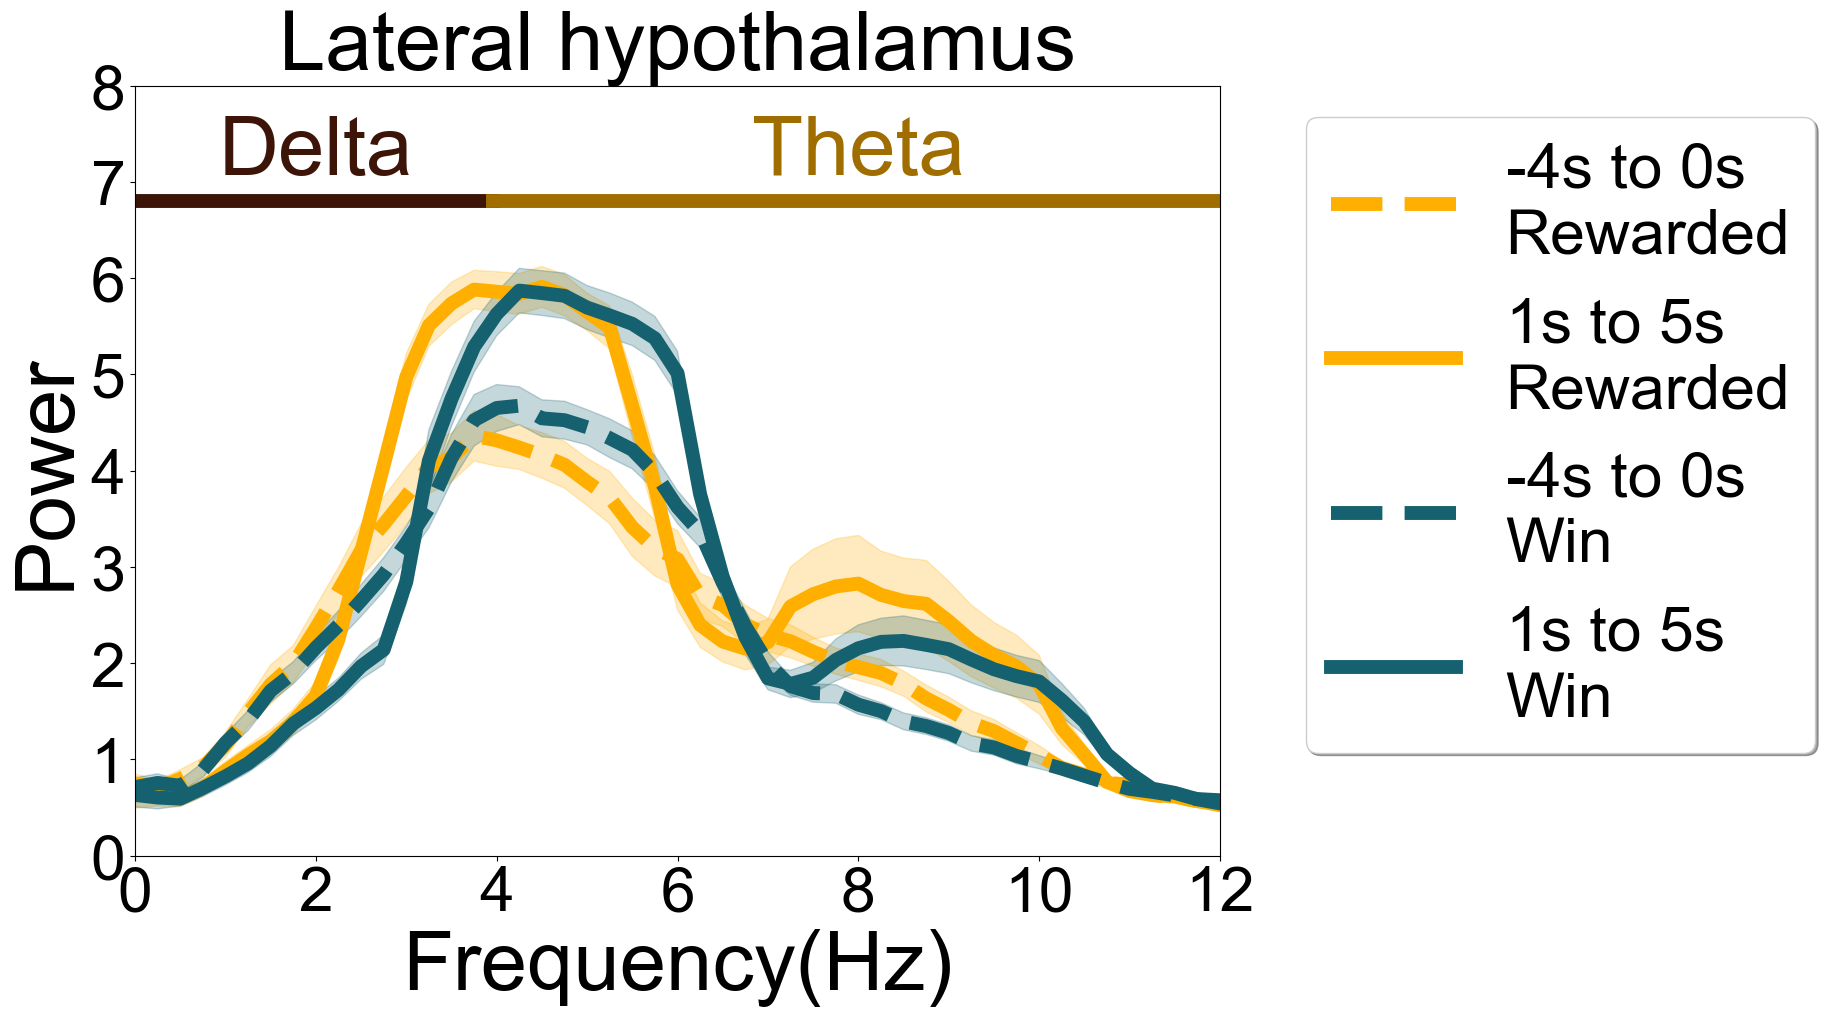

14
win


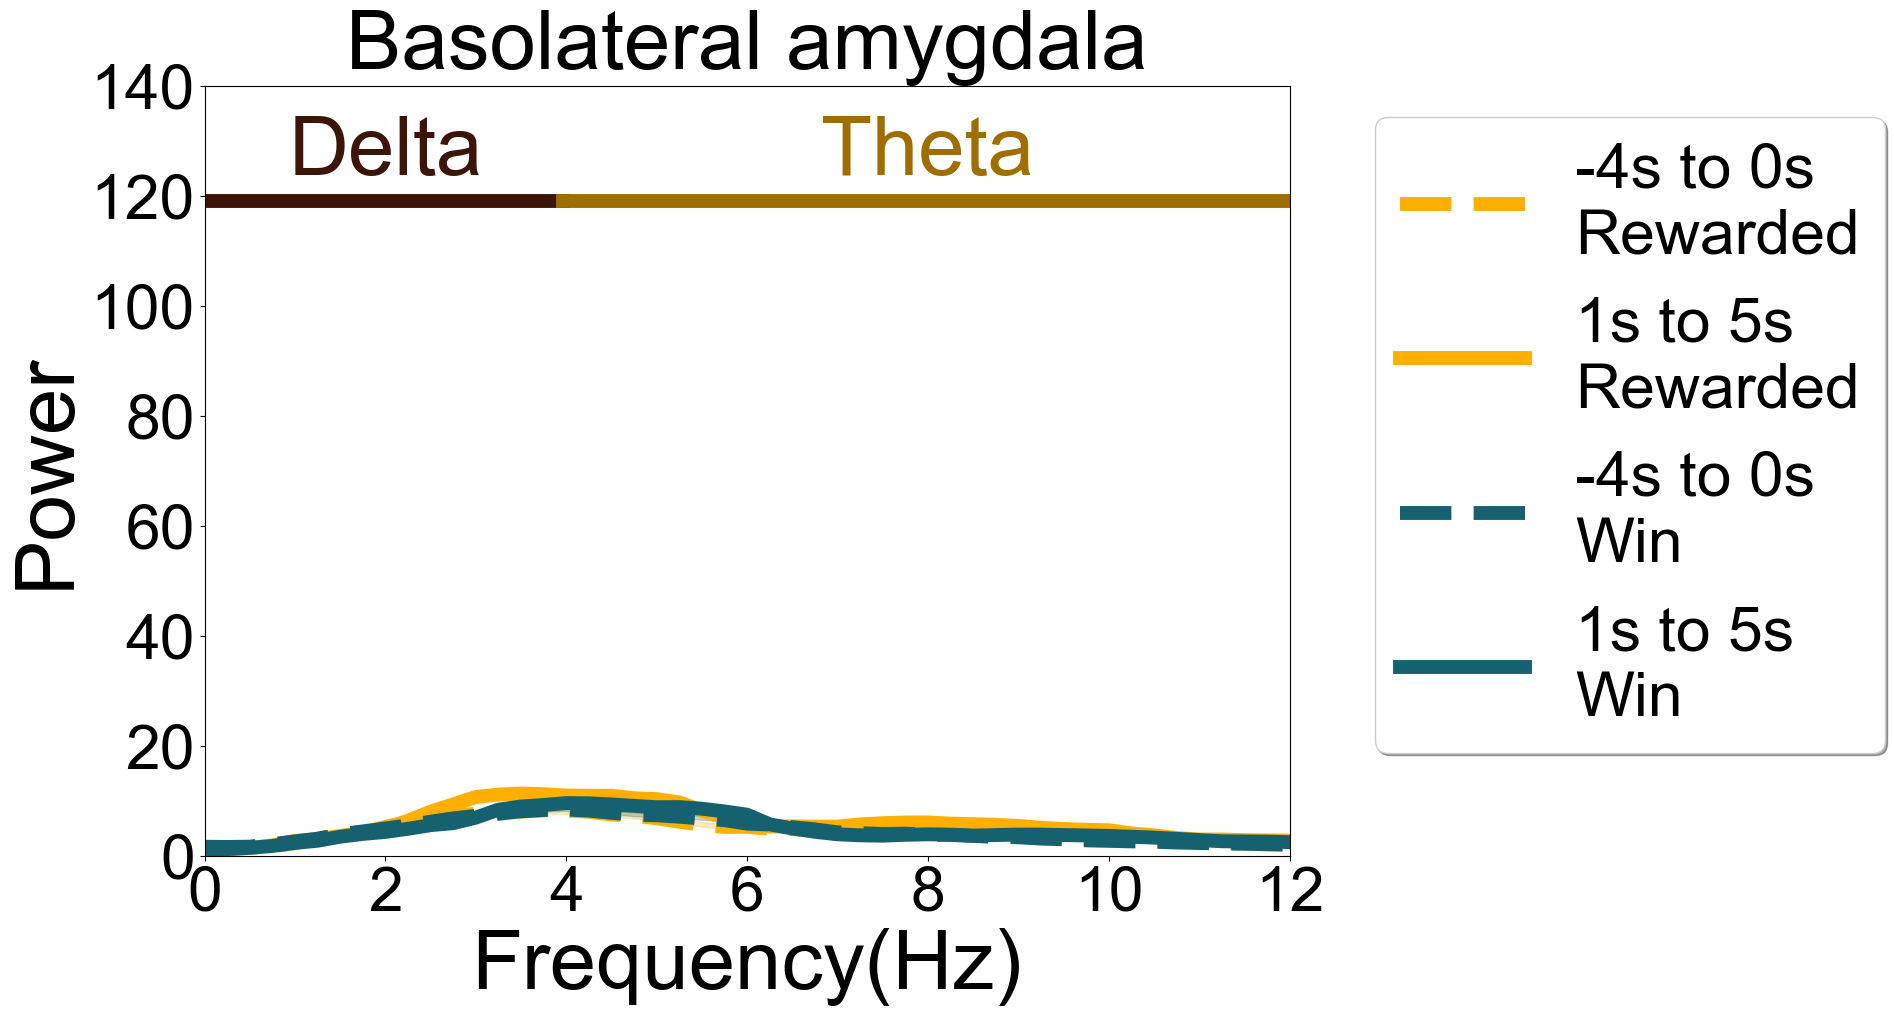

15
win


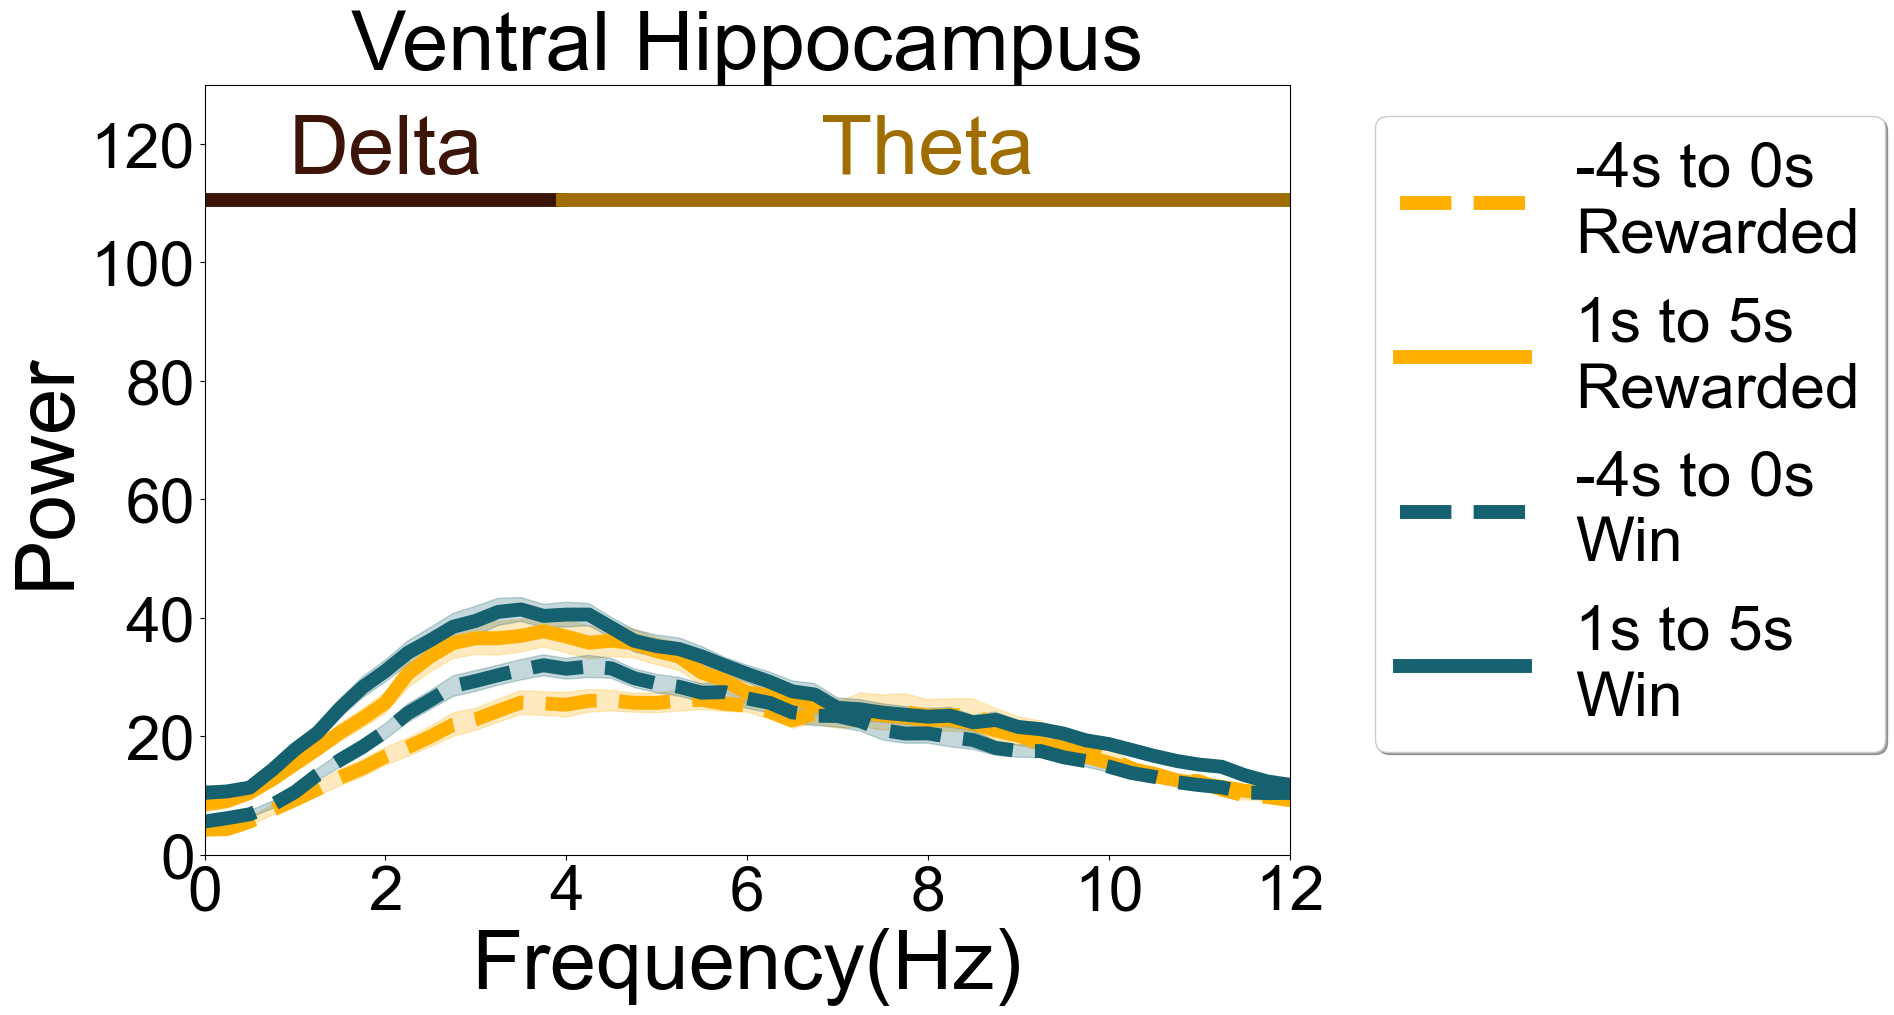

16
win


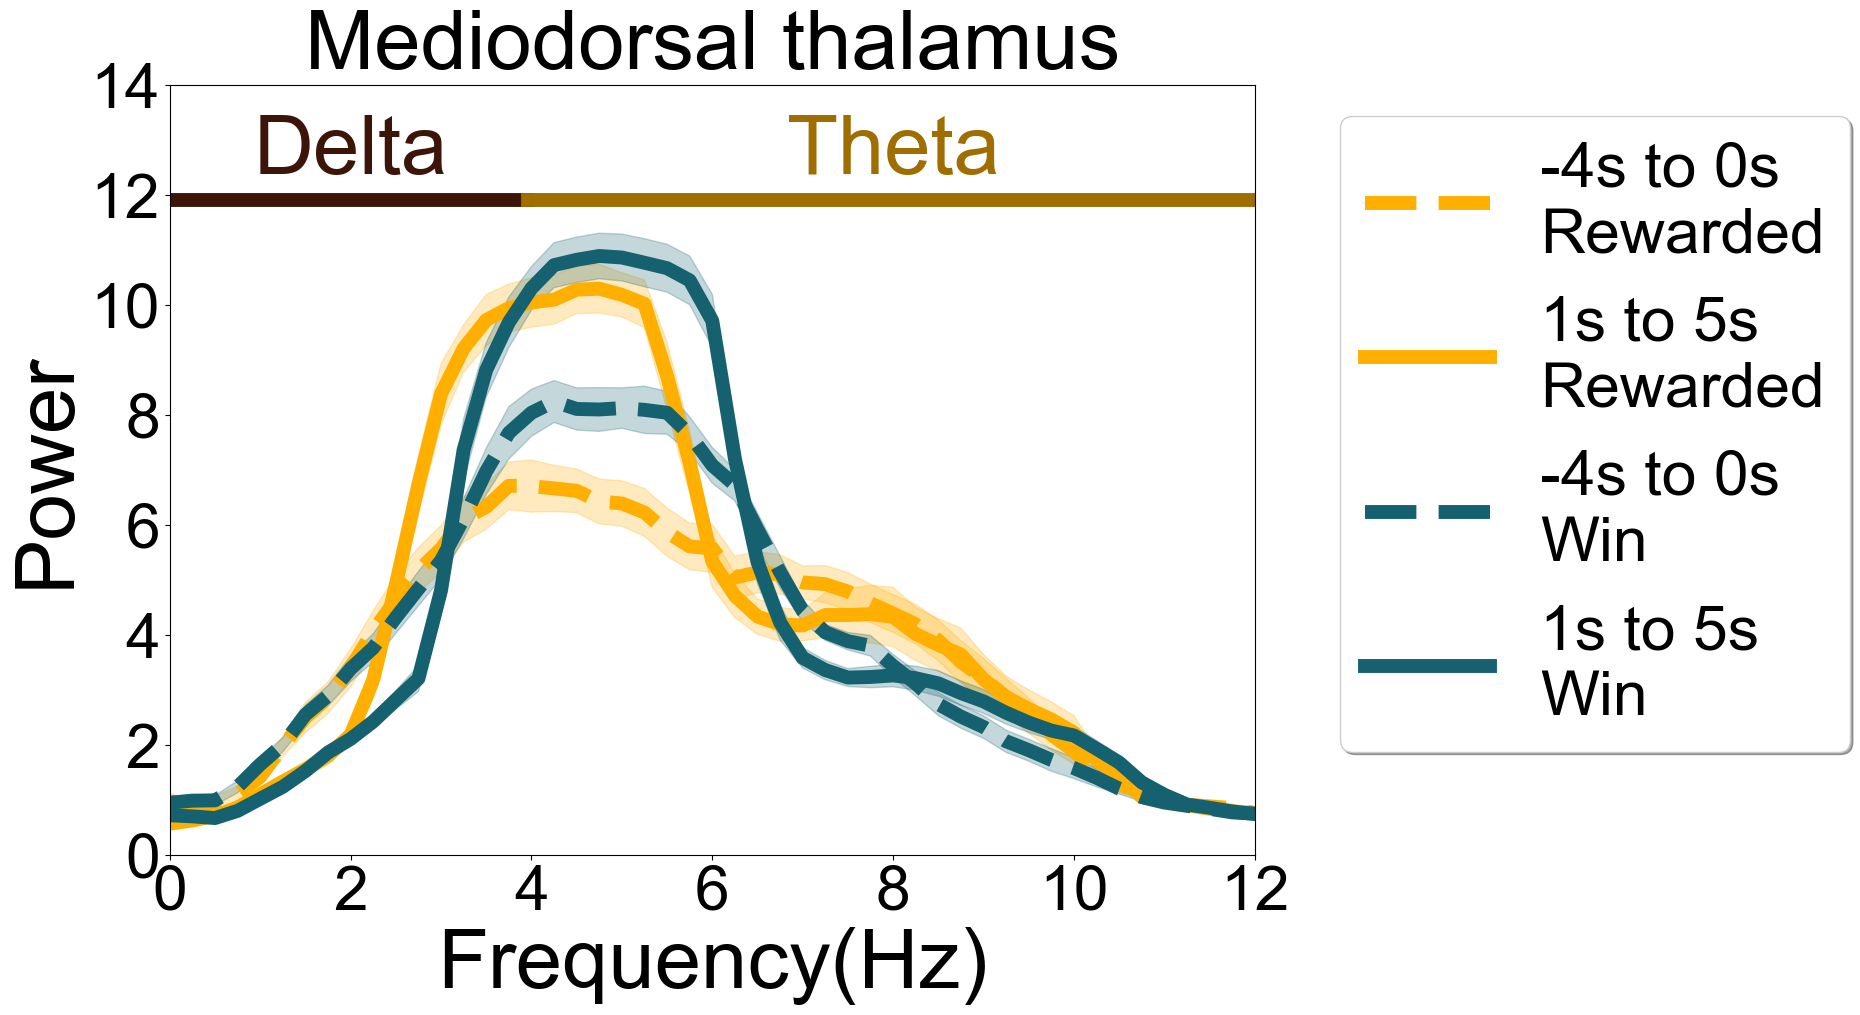

21
win


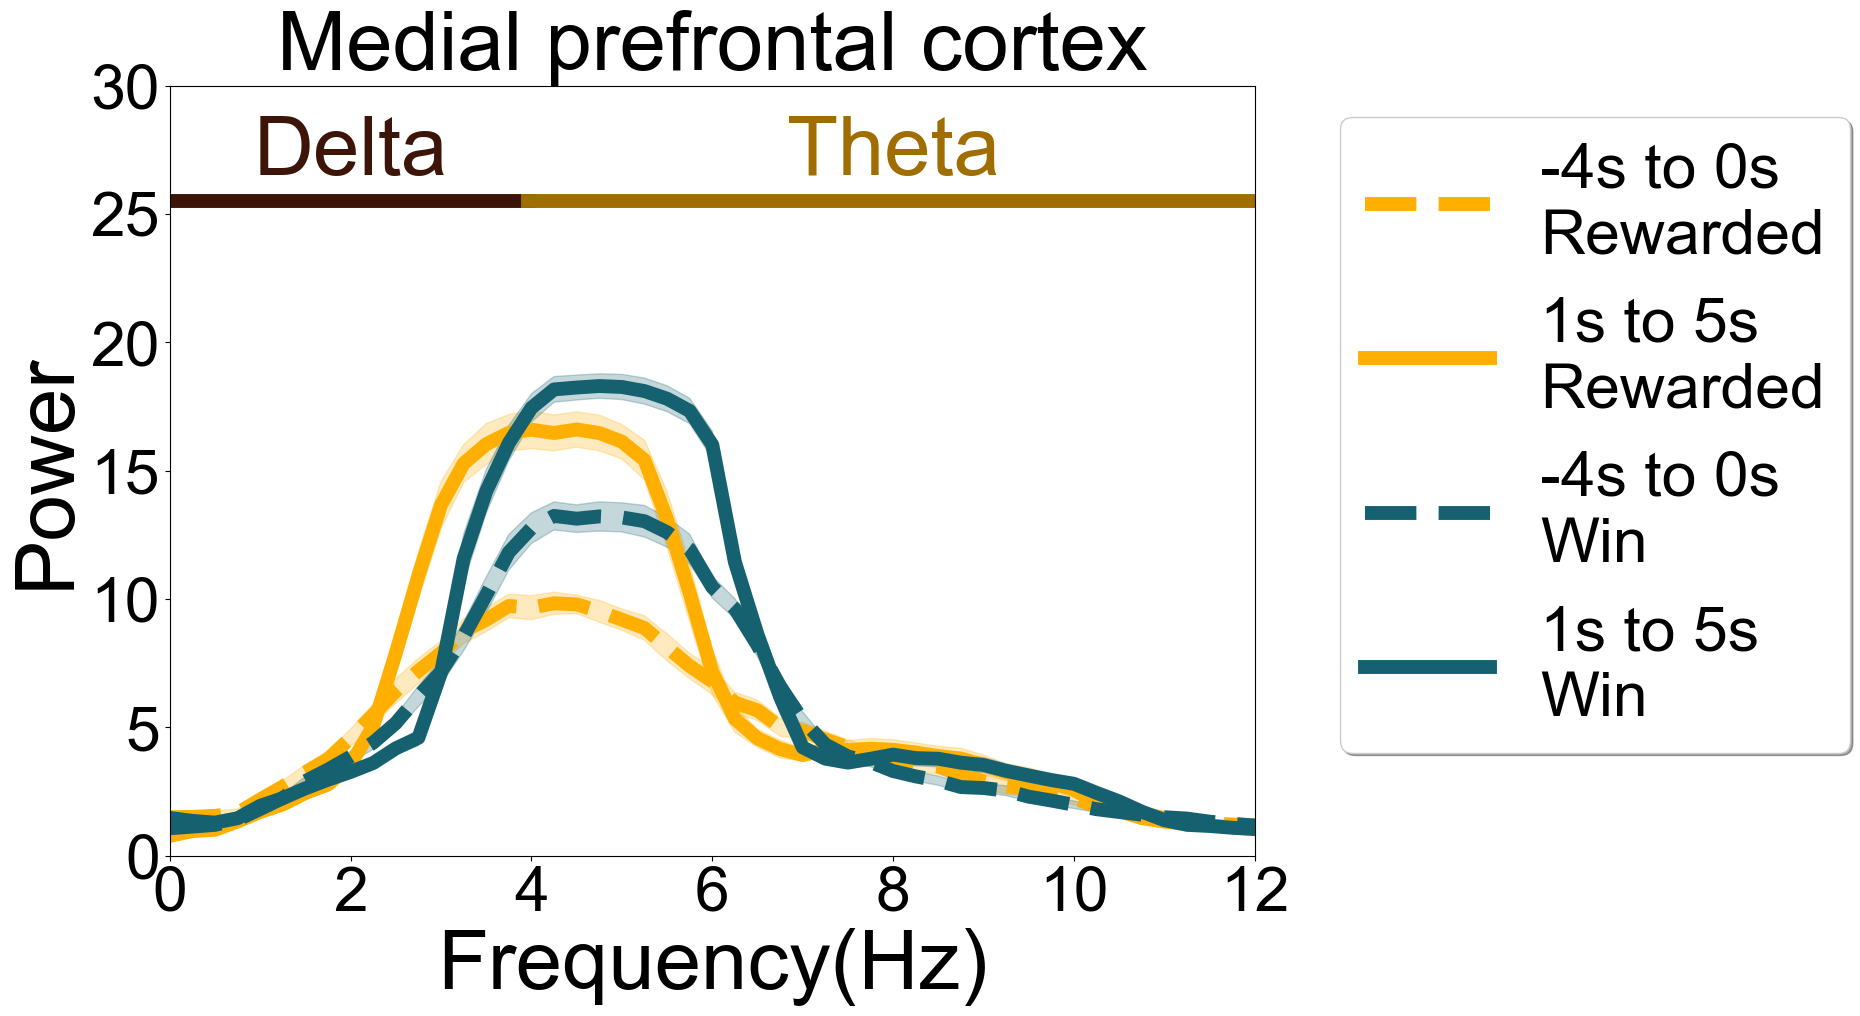

In [40]:
for channel in channel_id_to_brain_region.keys():
    print(channel)
    print(trial_type)
    plt.rcParams["figure.figsize"] = (14,10)
    fig, ax = plt.subplots()
    for trial_type in trials_with_reward:


        ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="-4s to 0s\n{}".format(trial_type.capitalize()), linestyle="--", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
        
        ax.plot(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="1s to 5s\n{}".format(trial_type.capitalize()), linestyle="-", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
    ax.set_xlabel("Frequency(Hz)", fontsize = AXESLABEL)
    ax.set_ylabel("Power", fontsize = AXESLABEL)
    plt.xticks(fontsize = AXESTICKS, family="Arial")
    plt.yticks(fontsize = AXESTICKS, family="Arial")

    
    ax.set_xlim(0,12)
    ax.set_ylim(0,brain_region_to_ylim[channel_id_to_brain_region[channel]])

    plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0, xmax=0.33, color='#3C1508', linestyle='-', linewidth=LINWID)
    plt.text(2, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Delta', fontsize = AXESLABEL, ha='center', color='#3C1508')
    plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0.33, xmax=1, color='#9F6D00', linestyle='-', linewidth=LINWID)
    plt.text(8, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Theta', fontsize = AXESLABEL, ha='center', color='#9F6D00')
    
    # ax.set_yscale("log")
    plt.title("{}".format(channel_id_to_brain_region[channel]), fontsize = TITLESIZE)
    plt.legend(fontsize = LEGSIZE, fancybox=True, frameon = True, shadow=True, loc="upper left", bbox_to_anchor=(1.05, 1))
#     plt.tight_layout()



    plt.savefig("./proc/plots/lfp_{}_{}_rewarded_trials.png".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
    plt.savefig("./proc/plots/lfp_{}_{}_rewarded_trials.svg".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
    plt.show()


In [41]:
mylabels = ['-4s to 0s Omission', '-4s to 0s Loss', '1s to 5s Omission', '1s to 5s Loss']

13
win


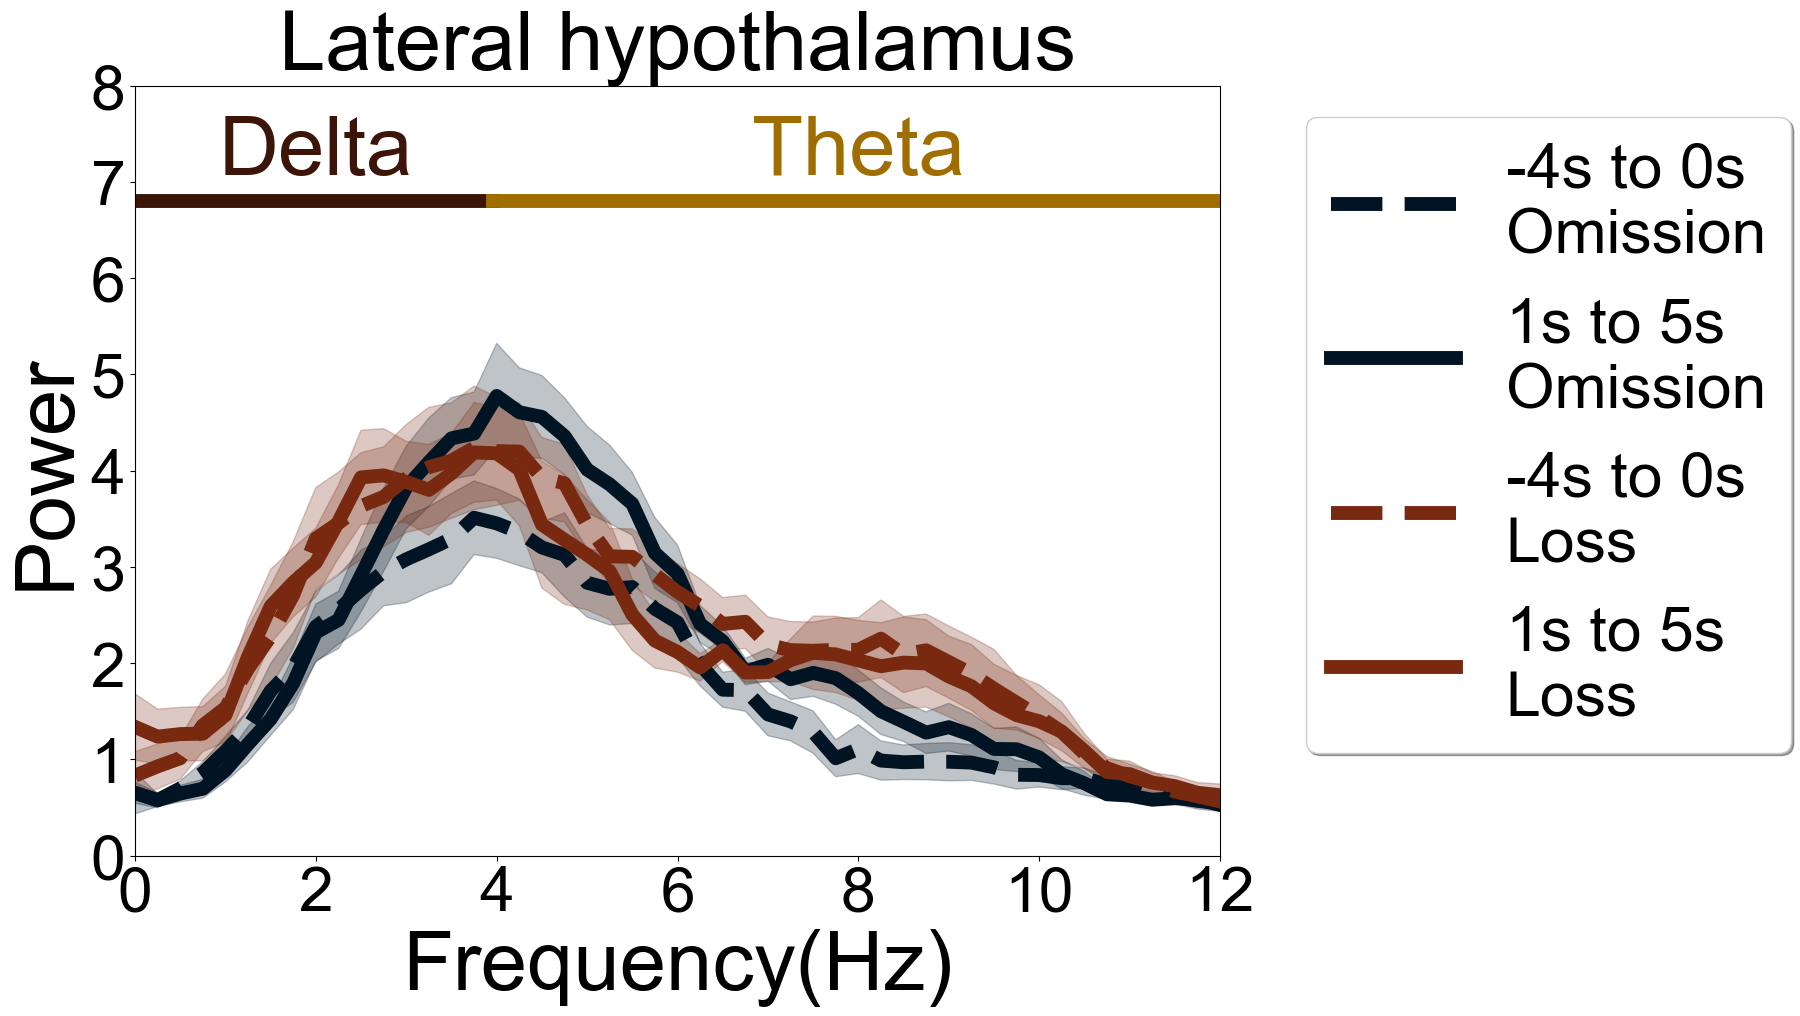

14
loss


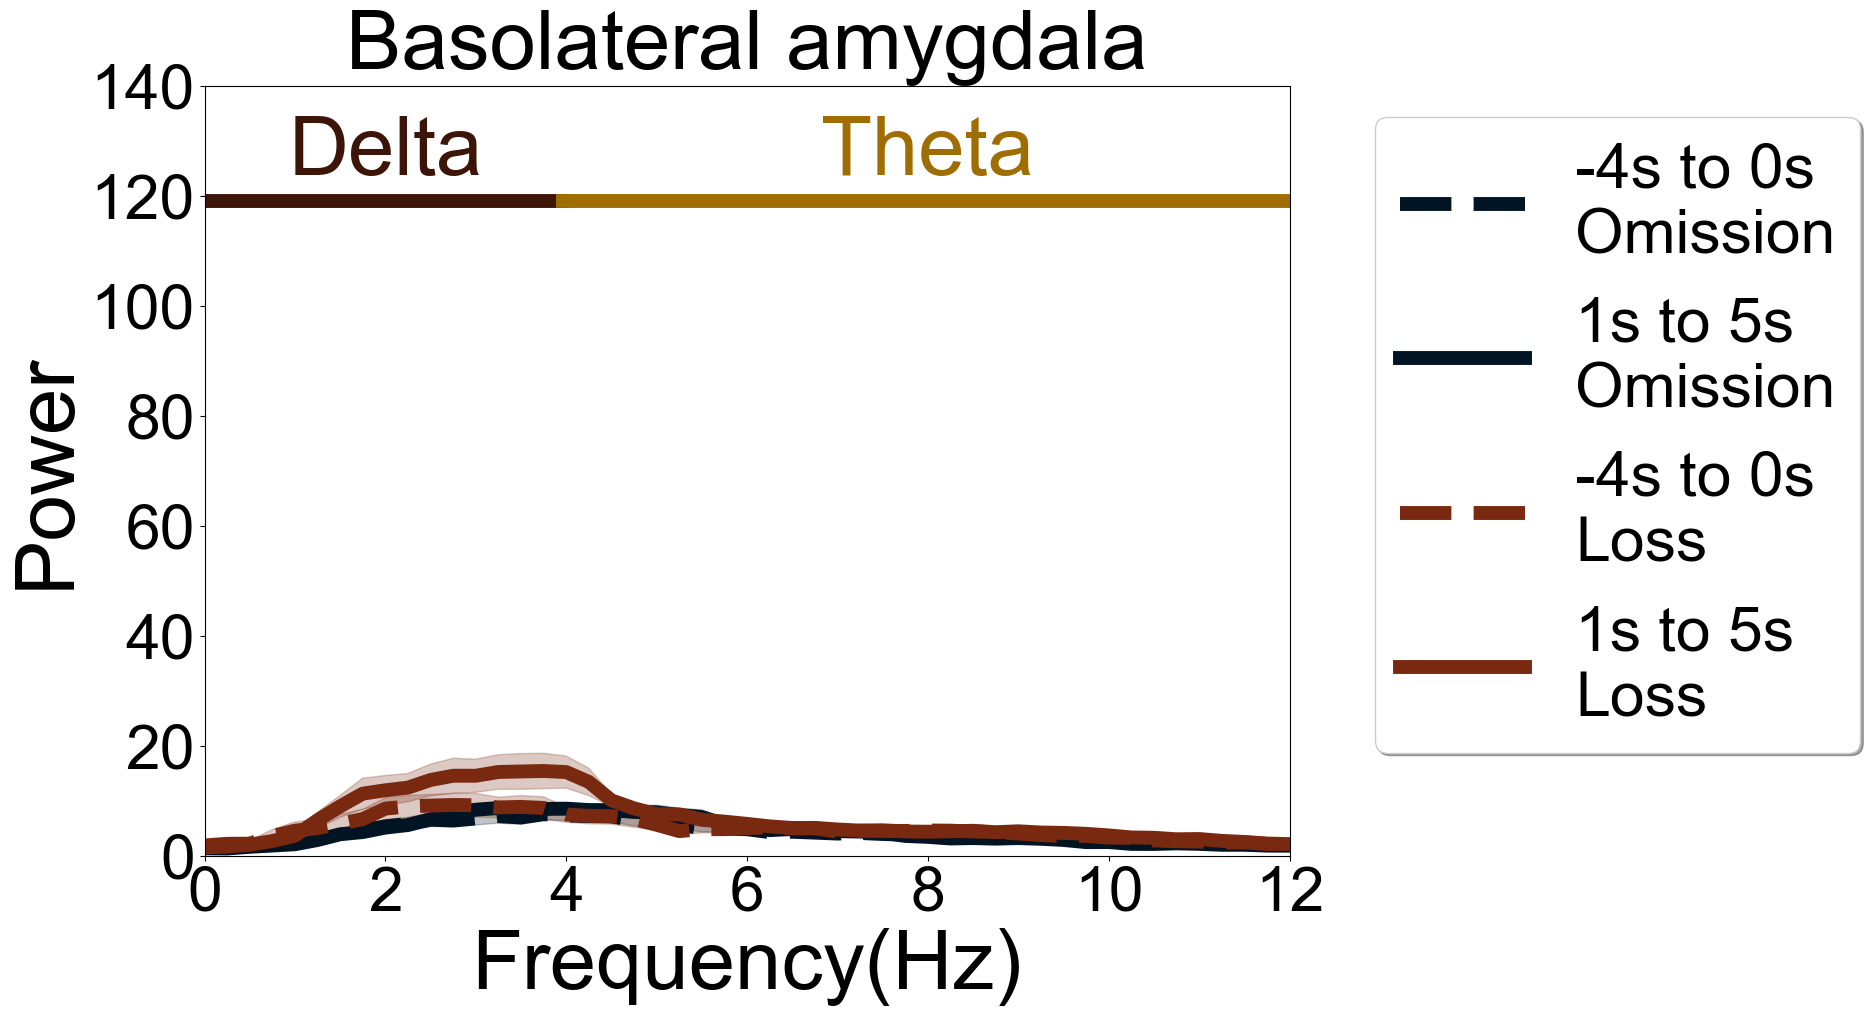

15
loss


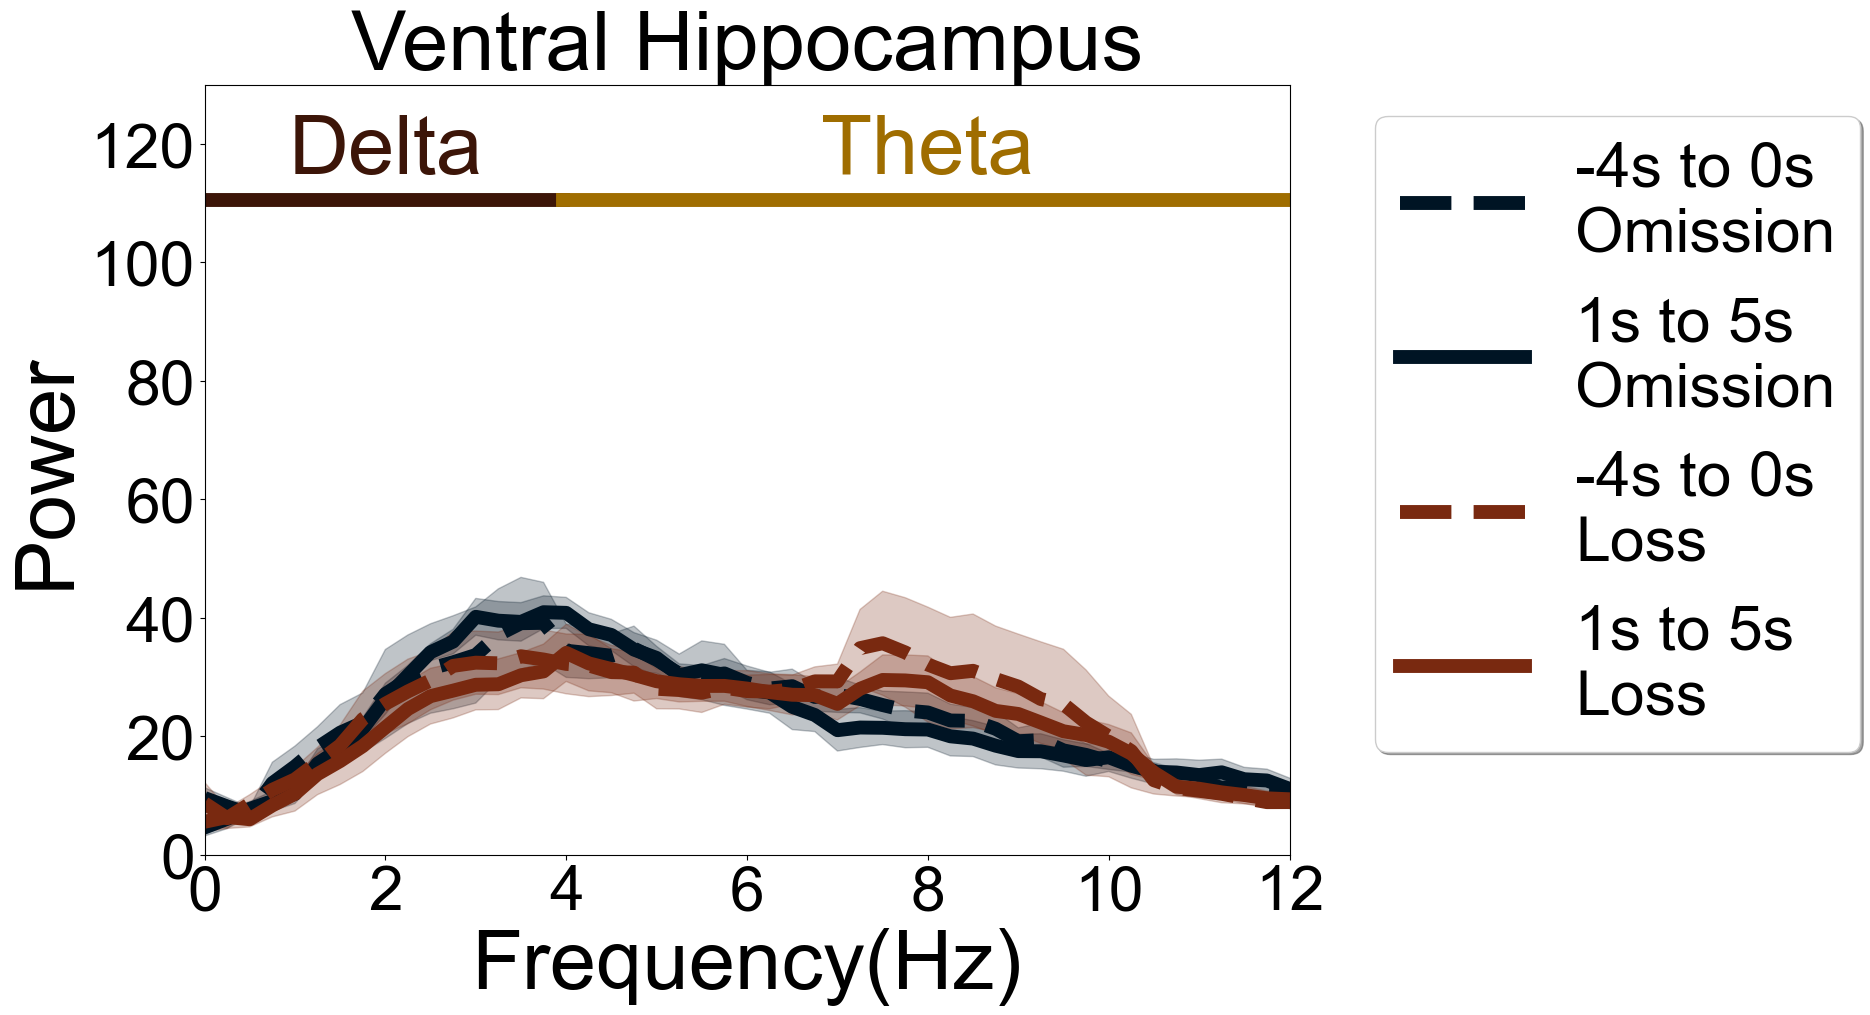

16
loss


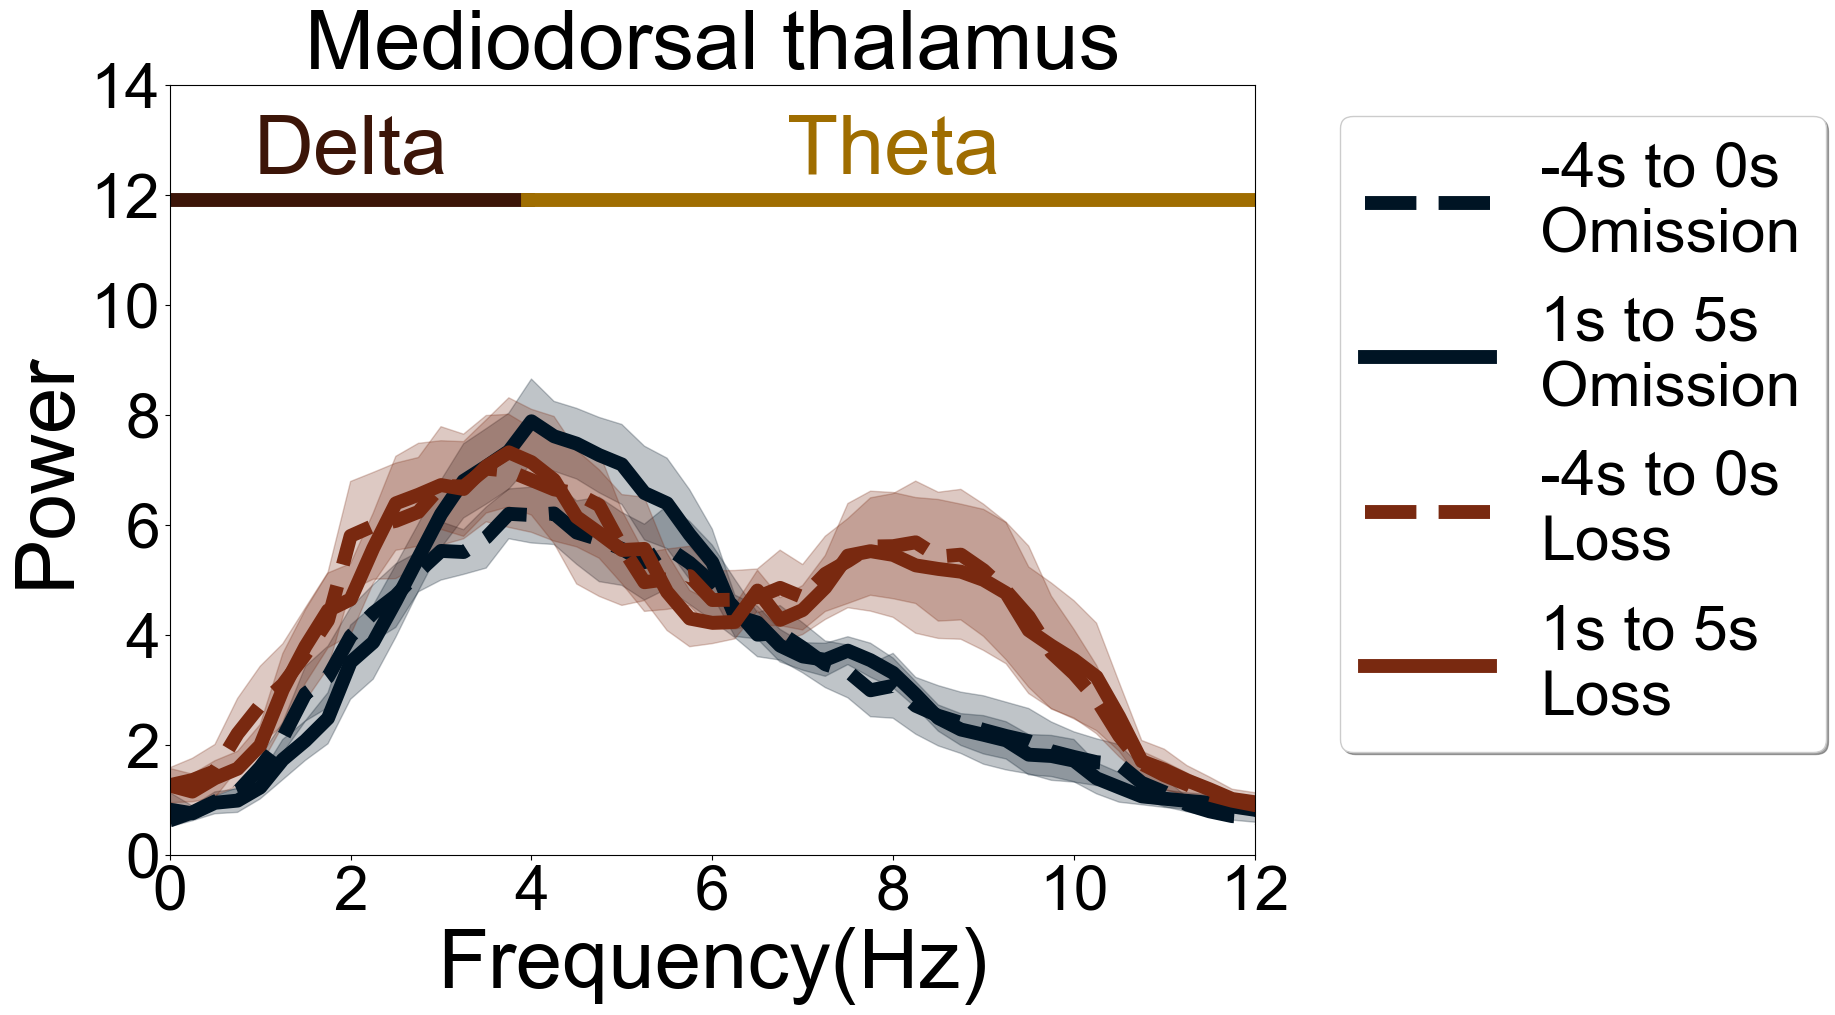

21
loss


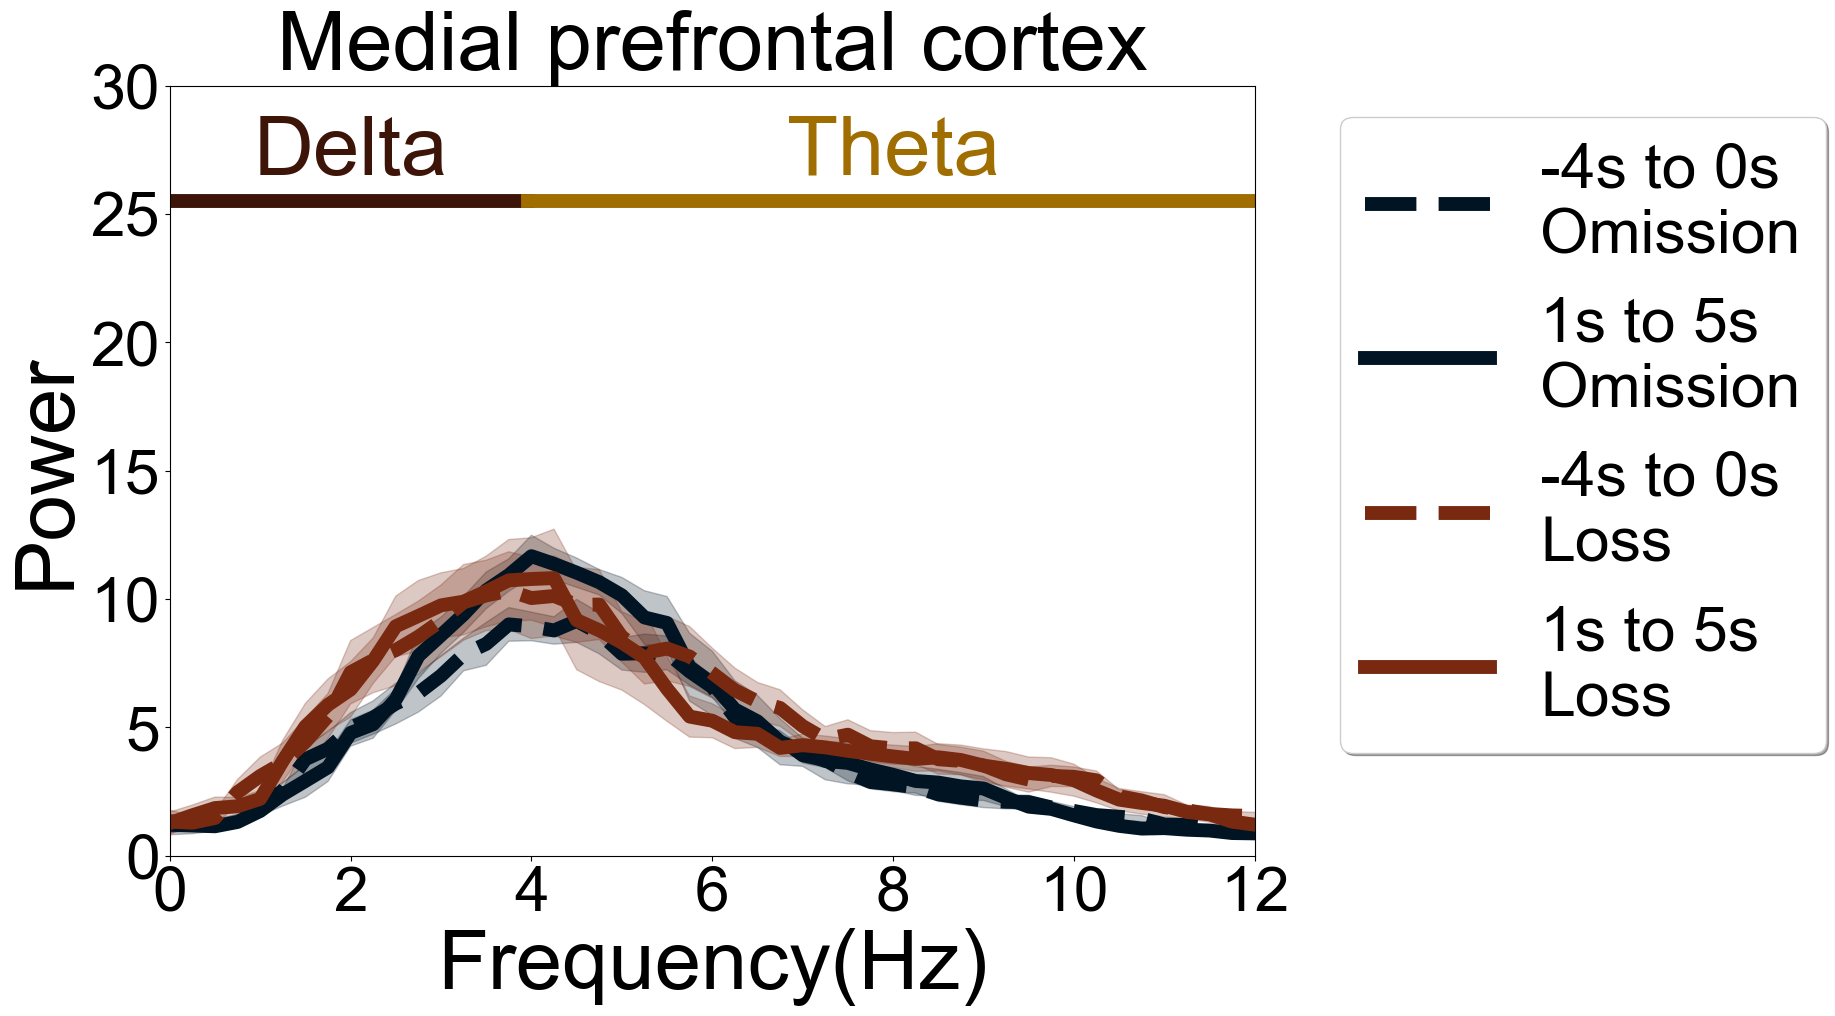

In [42]:
for channel in channel_id_to_brain_region.keys():
    print(channel)
    print(trial_type)
    plt.rcParams["figure.figsize"] = (14,10)
    fig, ax = plt.subplots()
    for trial_type in trials_without_reward:


        ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="-4s to 0s\n{}".format(trial_type.capitalize()), linestyle="--", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
        
        ax.plot(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="1s to 5s\n{}".format(trial_type.capitalize()), linestyle="-", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
    ax.set_xlabel("Frequency(Hz)", fontsize = AXESLABEL)
    ax.set_ylabel("Power", fontsize = AXESLABEL)
    plt.xticks(fontsize = AXESTICKS, family="Arial")
    plt.yticks(fontsize = AXESTICKS, family="Arial")

    
    ax.set_xlim(0,12)
    ax.set_ylim(0,brain_region_to_ylim[channel_id_to_brain_region[channel]])

    plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0, xmax=0.33, color='#3C1508', linestyle='-', linewidth=LINWID)
    plt.text(2, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Delta', fontsize = AXESLABEL, ha='center', color='#3C1508')
    plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0.33, xmax=1, color='#9F6D00', linestyle='-', linewidth=LINWID)
    plt.text(8, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Theta', fontsize = AXESLABEL, ha='center', color='#9F6D00')
    
    # ax.set_yscale("log")
    plt.title("{}".format(channel_id_to_brain_region[channel]), fontsize = TITLESIZE)
    plt.legend(fontsize = LEGSIZE, fancybox=True, frameon = True, shadow=True, loc="upper left", bbox_to_anchor=(1.05, 1))
#     plt.tight_layout()



    plt.savefig("./proc/plots/lfp_{}_{}_omission_trials.png".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
    plt.savefig("./proc/plots/lfp_{}_{}_omission_trials.svg".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
    plt.show()


# Looking at higher frequency

In [71]:
brain_region_to_ylim = {"Medial prefrontal cortex": 2,
"Lateral hypothalamus": 1,
"Mediodorsal thalamus": 2,
"Basolateral amygdala": 3,
"Ventral Hippocampus": 15}

In [72]:
mylabels = ['-4s to 0s Rewarded', '-4s to 0s Win', '1s to 5s Rewarded', '1s to 5s Win']

In [73]:
baseline_channel_to_trial_to_power

defaultdict(<function __main__.<lambda>()>,
            {'13': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'win': defaultdict(list,
                                      {'all_traces': [array([[2.11297500e+03, 2.56481989e+03, 1.65038953e+03, ...,
                                                2.70457154e-03, 2.59006119e-03, 2.50176172e-03],
                                               [6.62699213e+02, 8.85206873e+02, 8.09515761e+02, ...,
                                                1.62859731e-03, 1.71252604e-03, 1.59047379e-03],
                                               [6.29403811e+02, 8.14081846e+02, 7.62529801e+02, ...,
                                                3.24899639e-04, 3.40688785e-04, 2.82089682e-04],
                                               ...,
                                               [1.31313428e+02, 2.11158982e+02, 2.15004538e+02, ...,
                                                2.04102047e-03,

13
loss


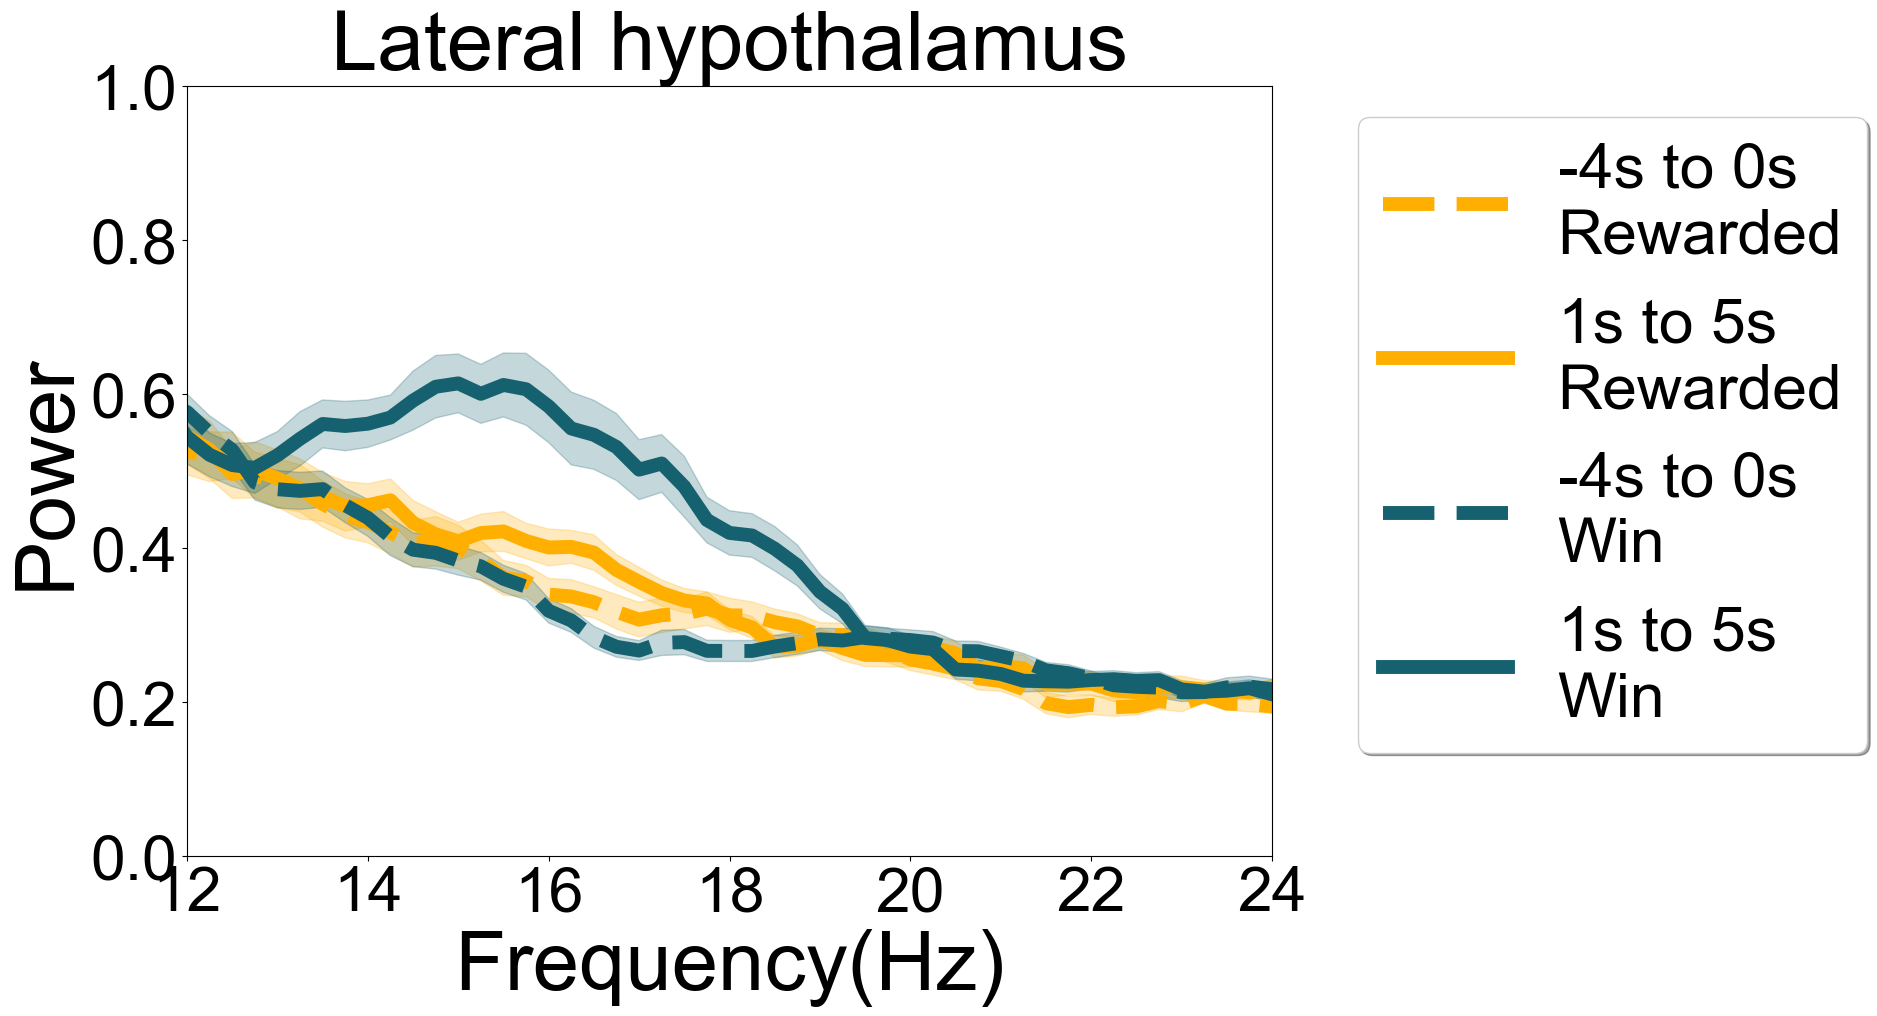

14
win


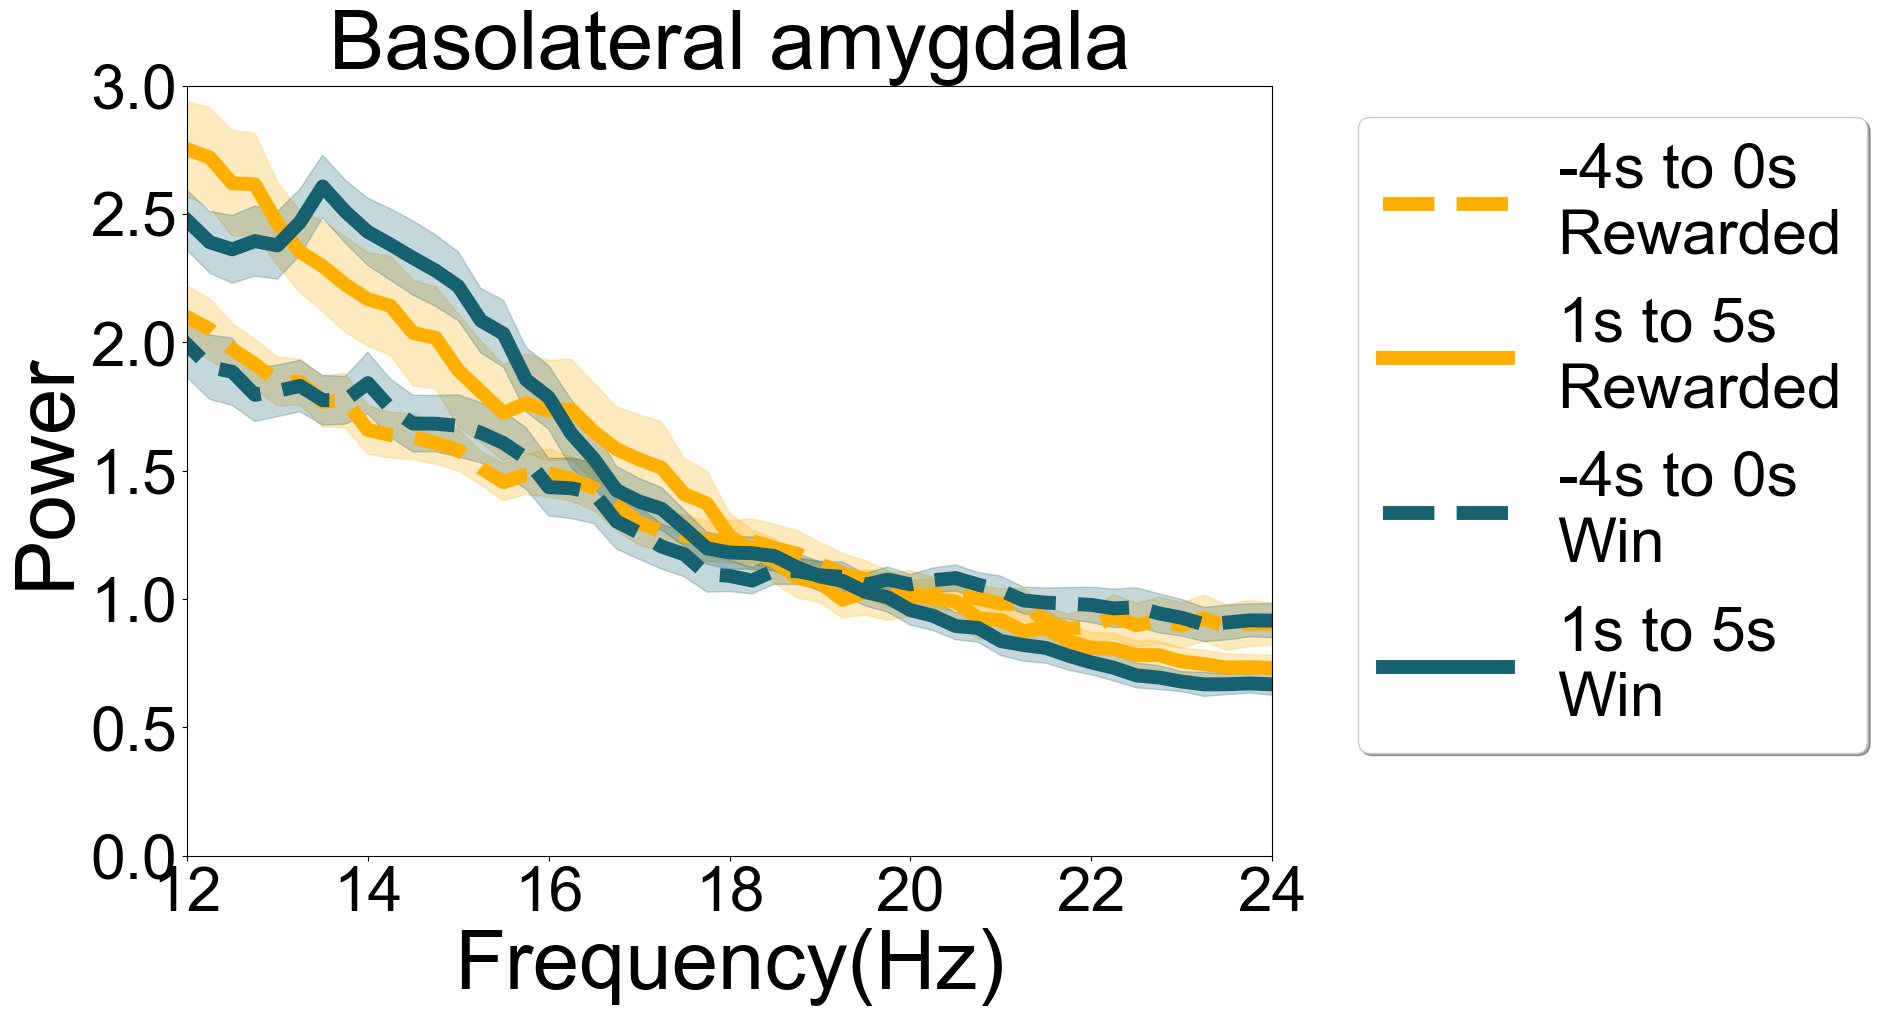

15
win


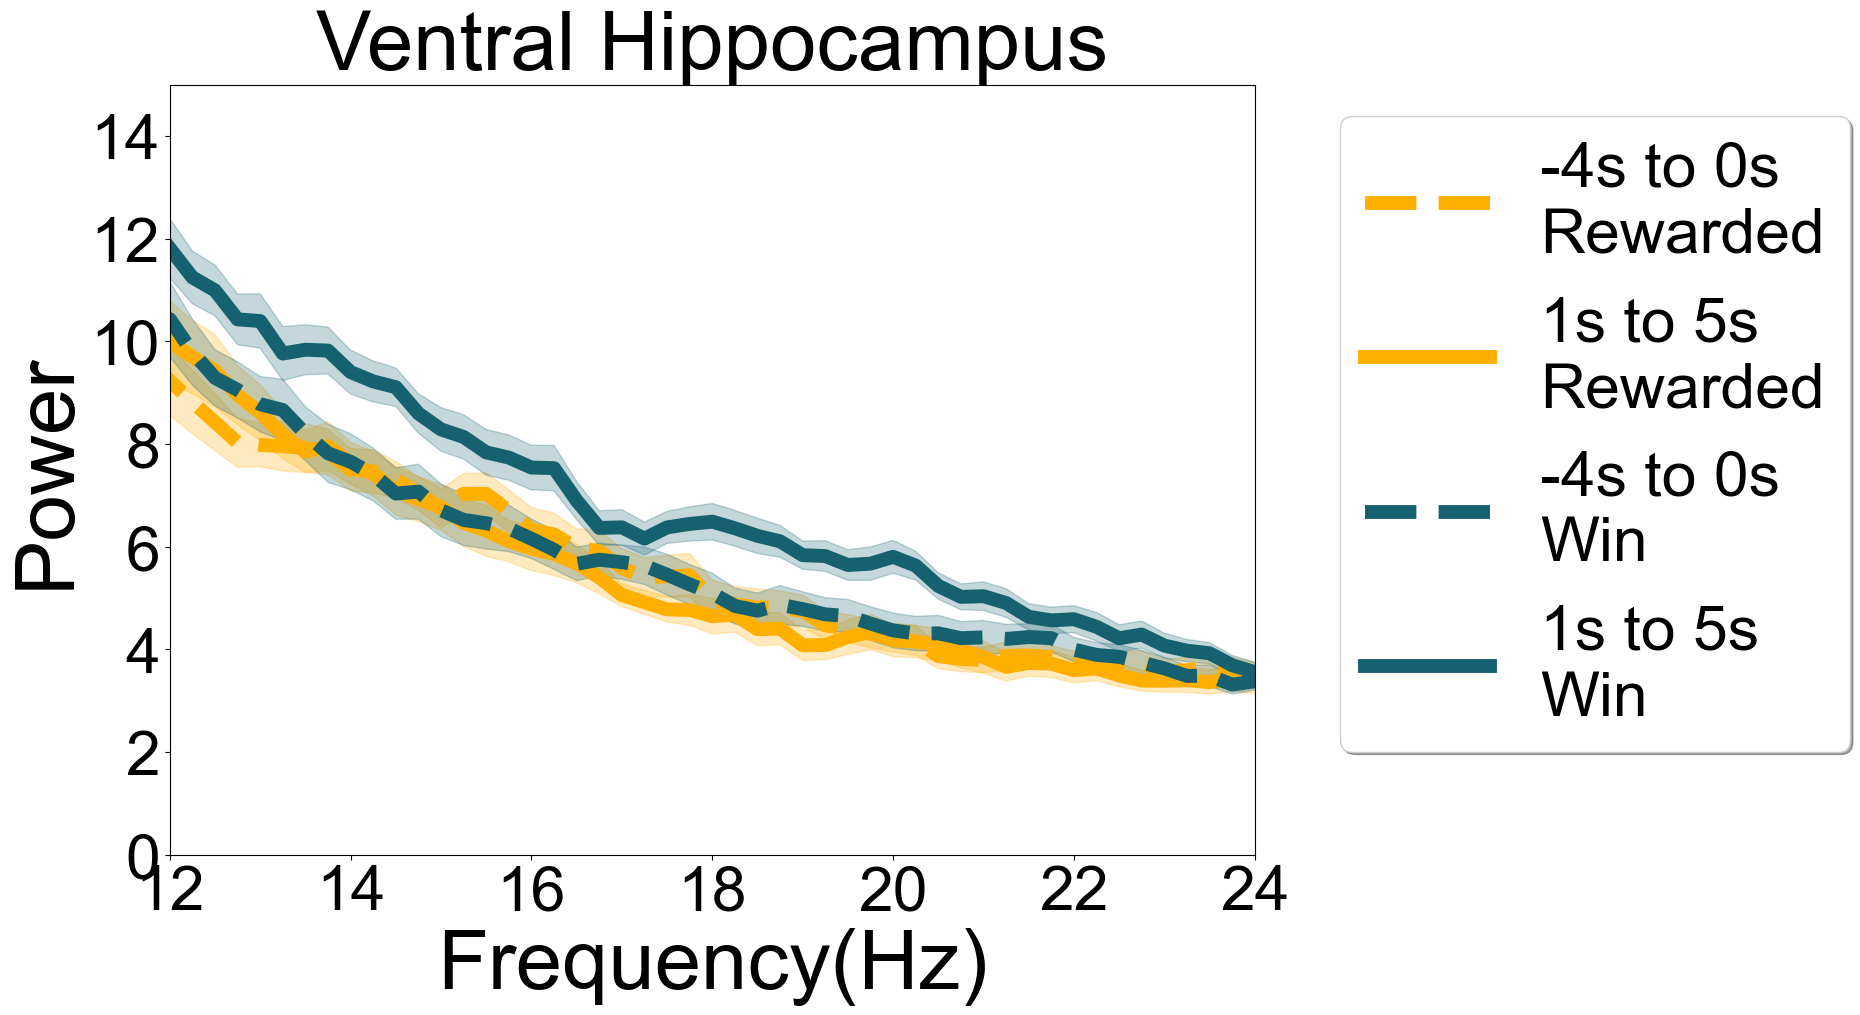

16
win


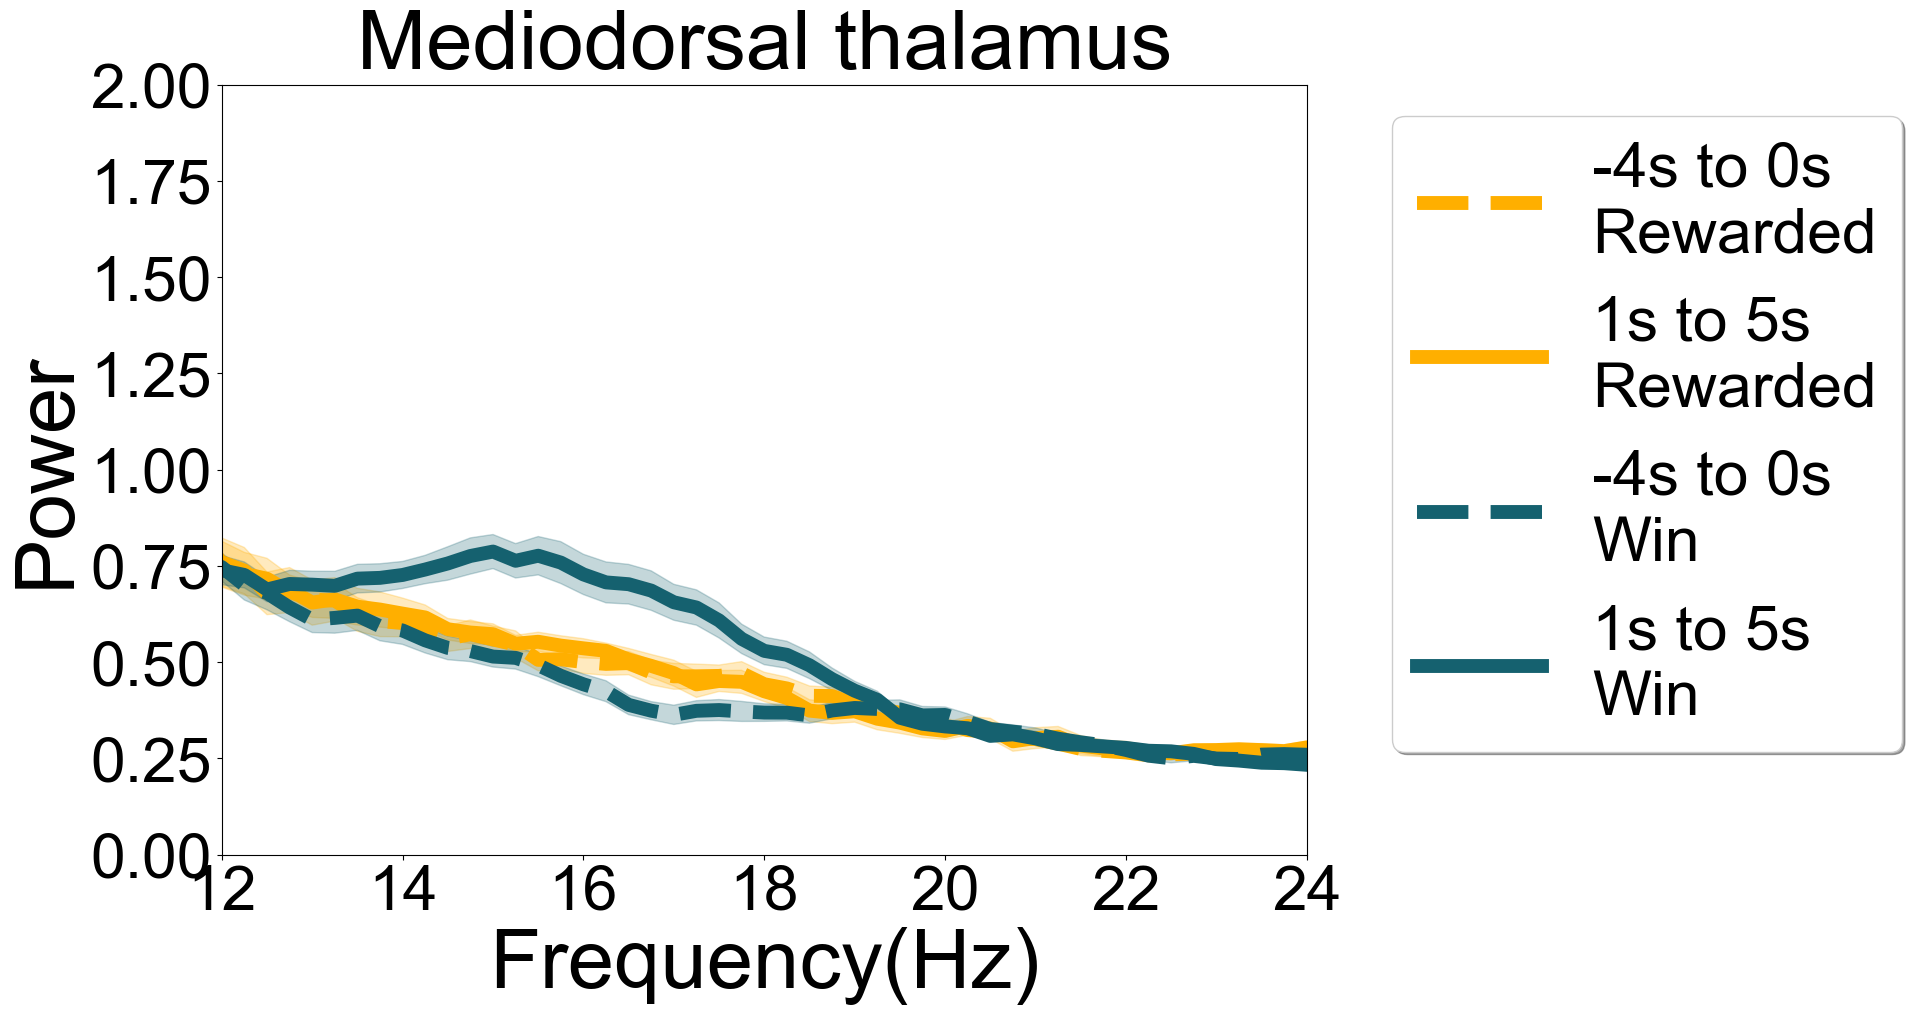

21
win


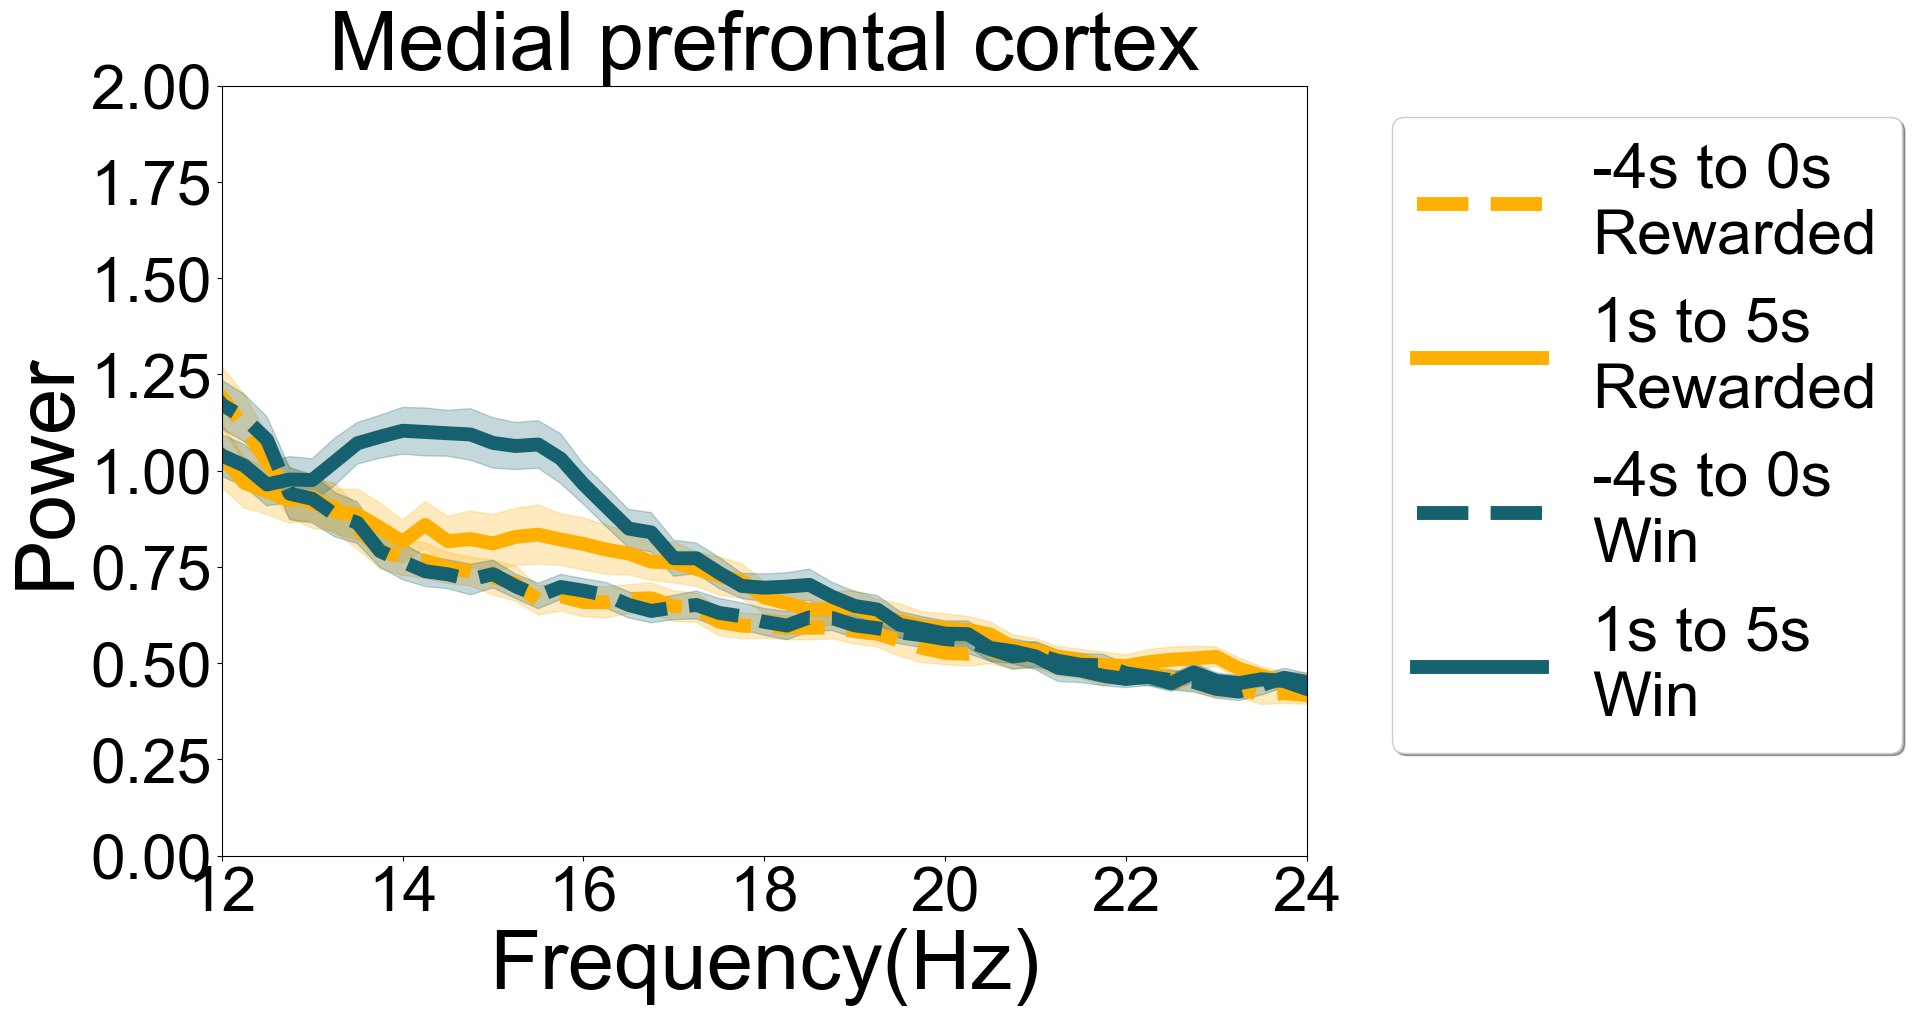

In [74]:
for channel in channel_id_to_brain_region.keys():
    print(channel)
    print(trial_type)
    plt.rcParams["figure.figsize"] = (14,10)
    fig, ax = plt.subplots()
    for trial_type in trials_with_reward:


        ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="-4s to 0s\n{}".format(trial_type.capitalize()), linestyle="--", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
        
        ax.plot(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="1s to 5s\n{}".format(trial_type.capitalize()), linestyle="-", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
    ax.set_xlabel("Frequency(Hz)", fontsize = AXESLABEL)
    ax.set_ylabel("Power", fontsize = AXESLABEL)
    plt.xticks(fontsize = AXESTICKS, family="Arial")
    plt.yticks(fontsize = AXESTICKS, family="Arial")

    
    ax.set_xlim(12,24)
    ax.set_ylim(0,brain_region_to_ylim[channel_id_to_brain_region[channel]])

#     plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0, xmax=0.33, color='#3C1508', linestyle='-', linewidth=LINWID)
#     plt.text(2, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Delta', fontsize = AXESLABEL, ha='center', color='#3C1508')
#     plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0.33, xmax=1, color='#9F6D00', linestyle='-', linewidth=LINWID)
#     plt.text(8, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Theta', fontsize = AXESLABEL, ha='center', color='#9F6D00')
    
    # ax.set_yscale("log")
    plt.title("{}".format(channel_id_to_brain_region[channel]), fontsize = TITLESIZE)
    plt.legend(fontsize = LEGSIZE, fancybox=True, frameon = True, shadow=True, loc="upper left", bbox_to_anchor=(1.05, 1))
#     plt.tight_layout()



#     plt.savefig("./proc/plots/lfp_{}_{}_rewarded_trials.png".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
#     plt.savefig("./proc/plots/lfp_{}_{}_rewarded_trials.svg".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
    plt.show()


In [75]:
mylabels = ['-4s to 0s Omission', '-4s to 0s Loss', '1s to 5s Omission', '1s to 5s Loss']

13
win


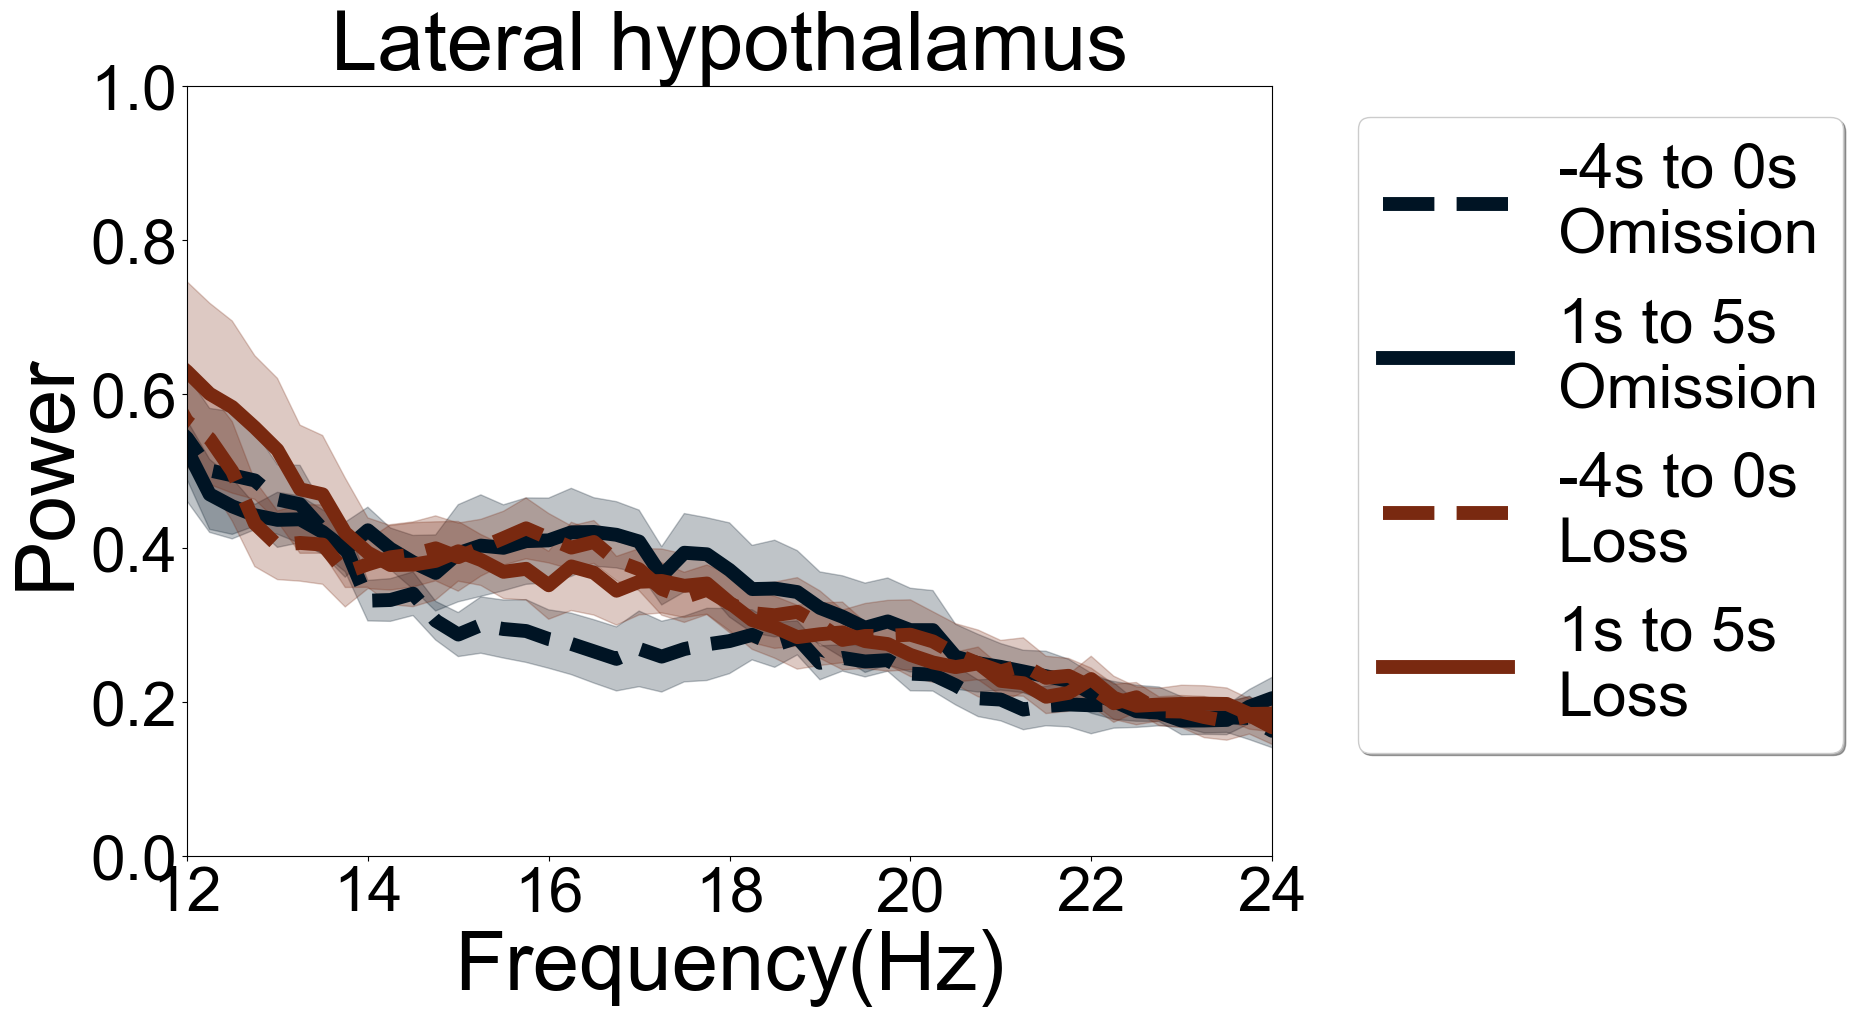

14
loss


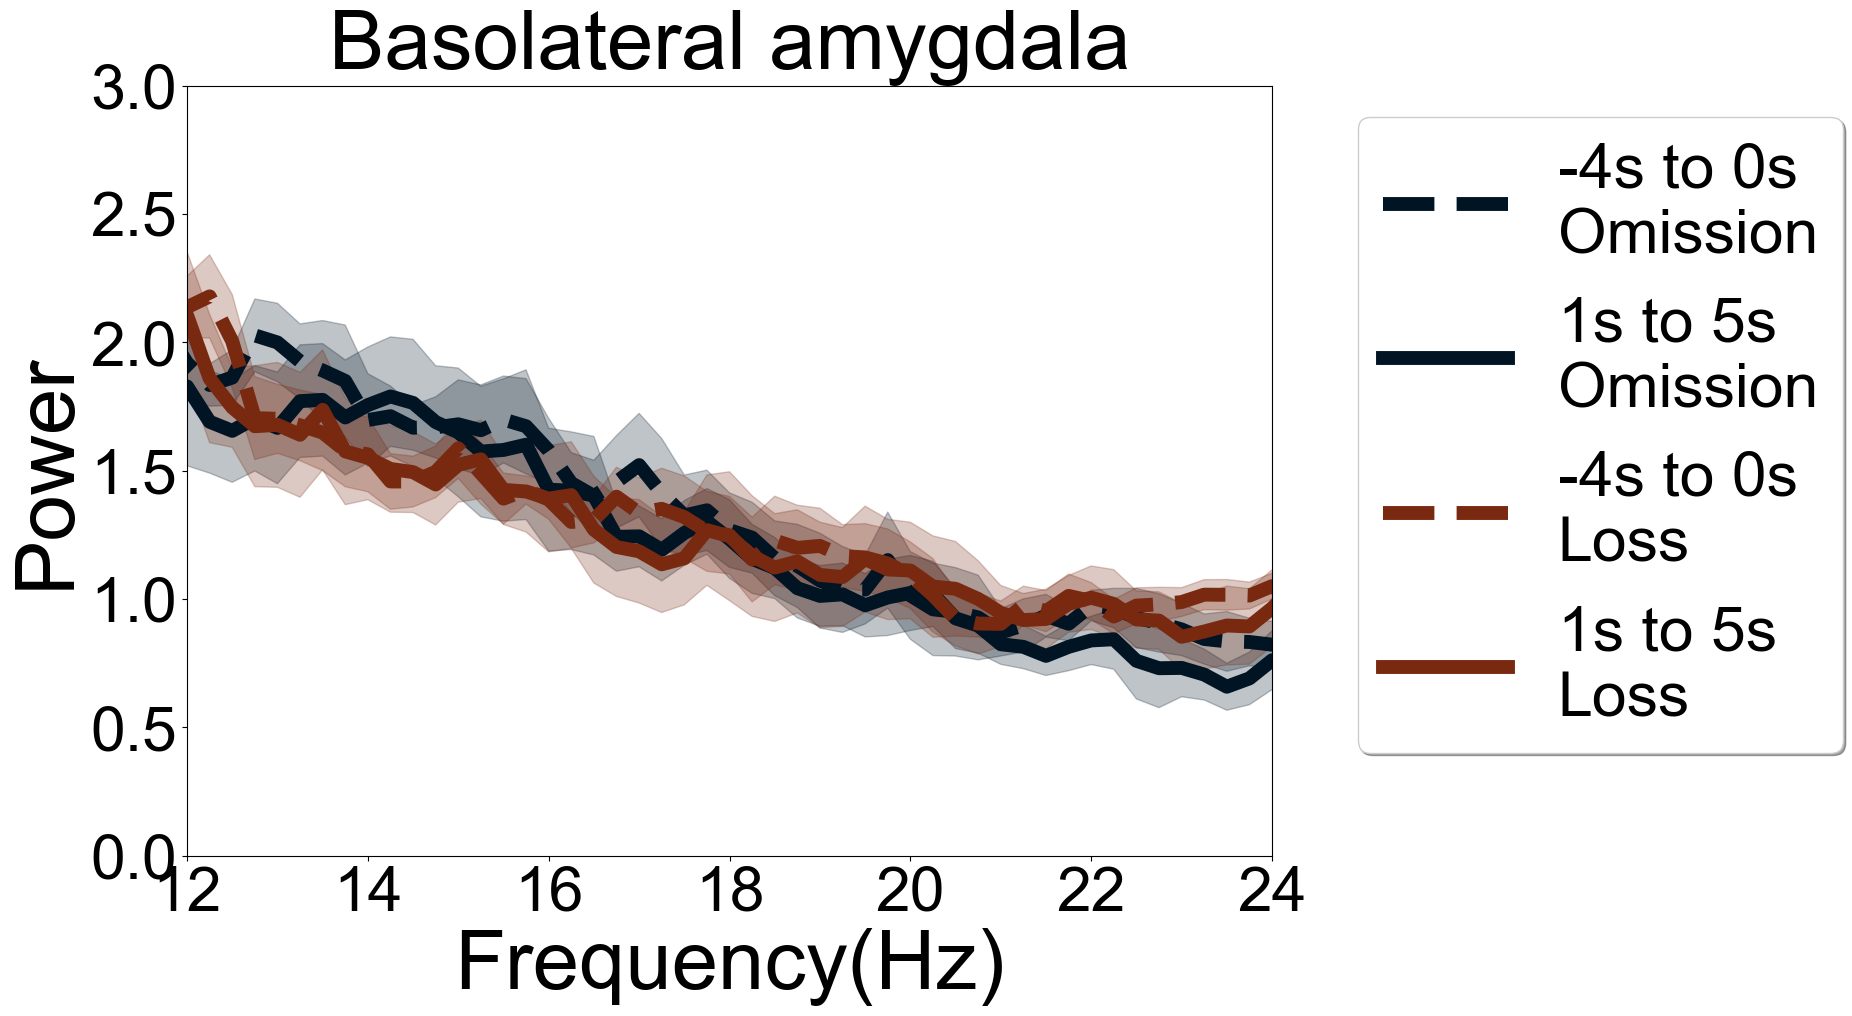

15
loss


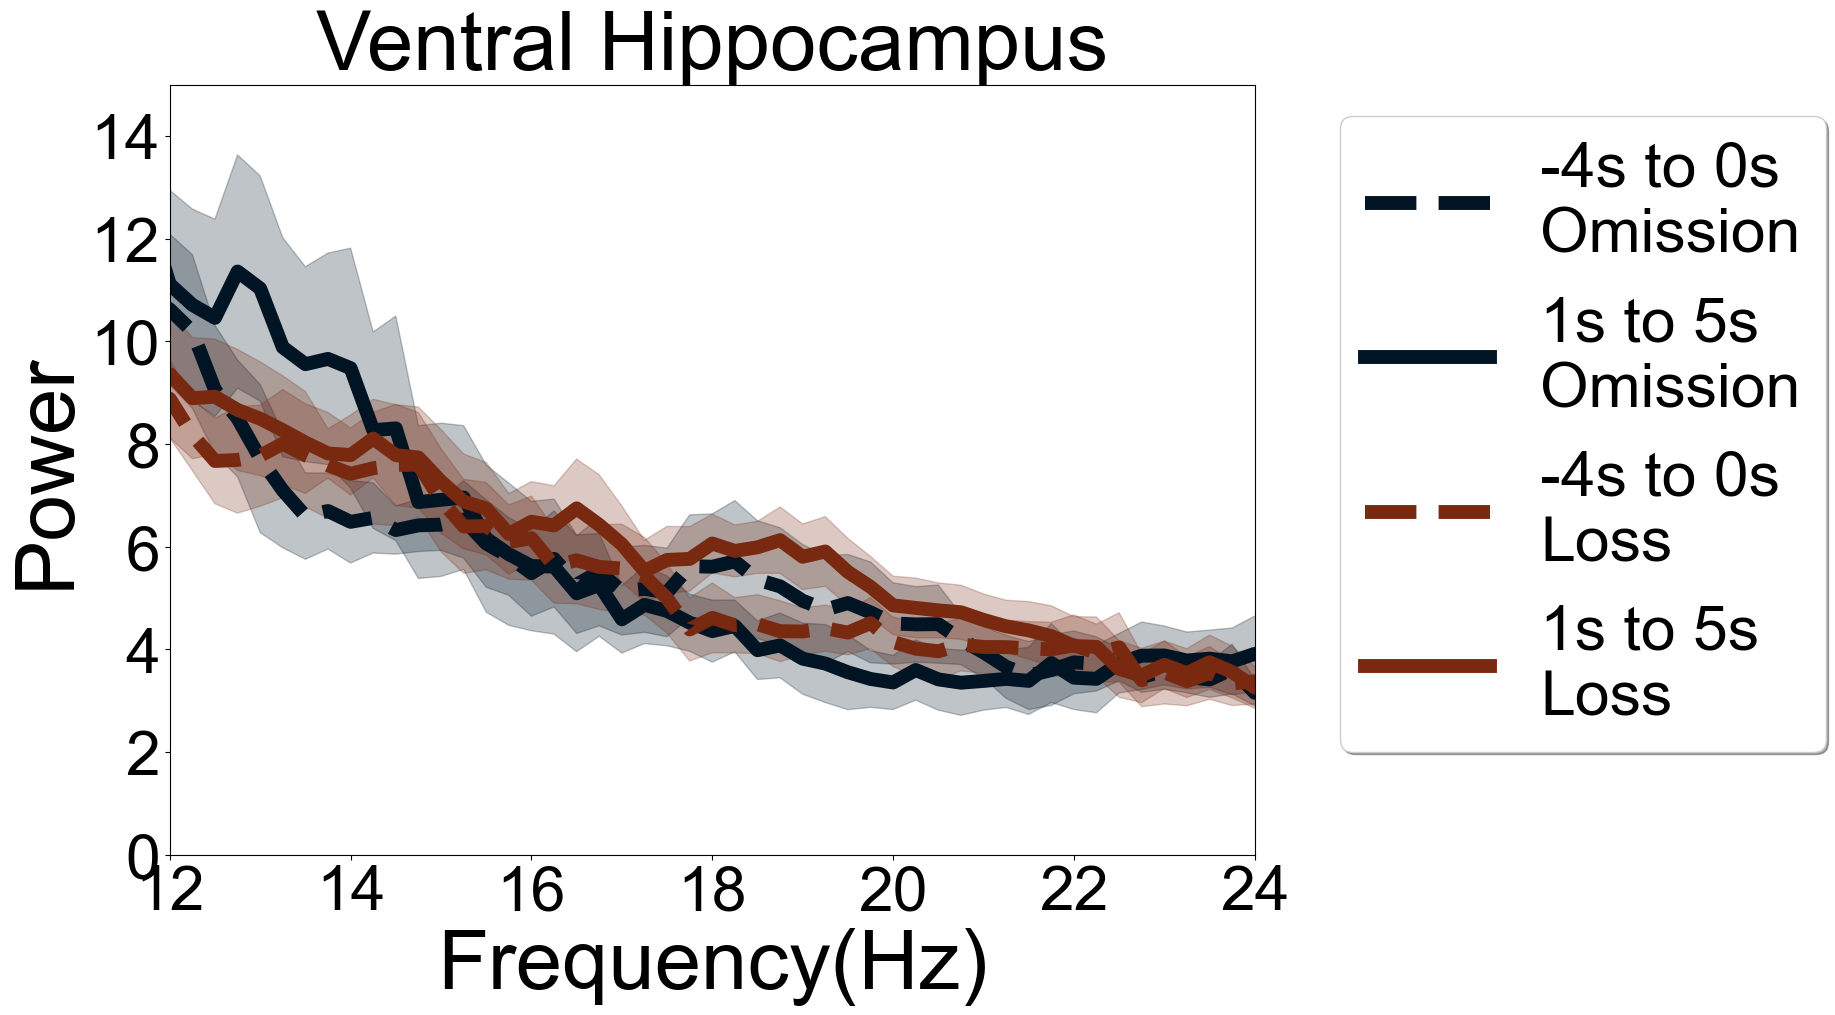

16
loss


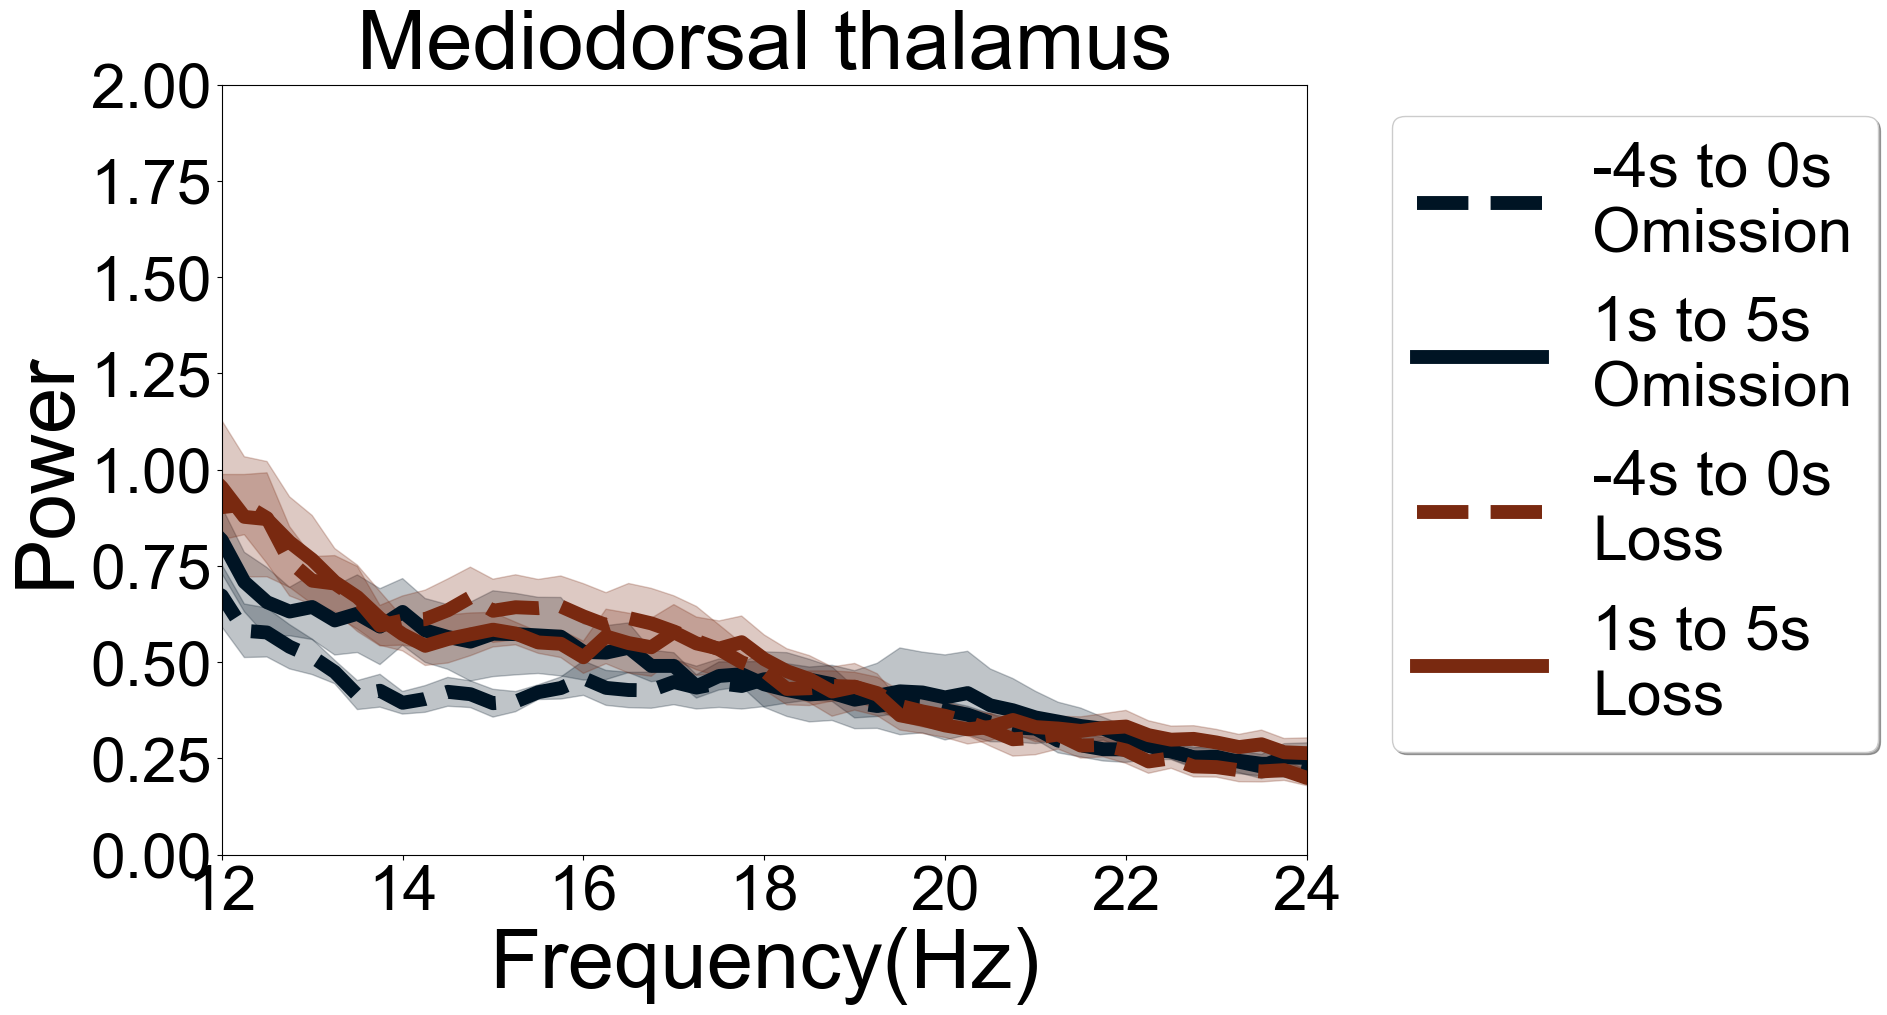

21
loss


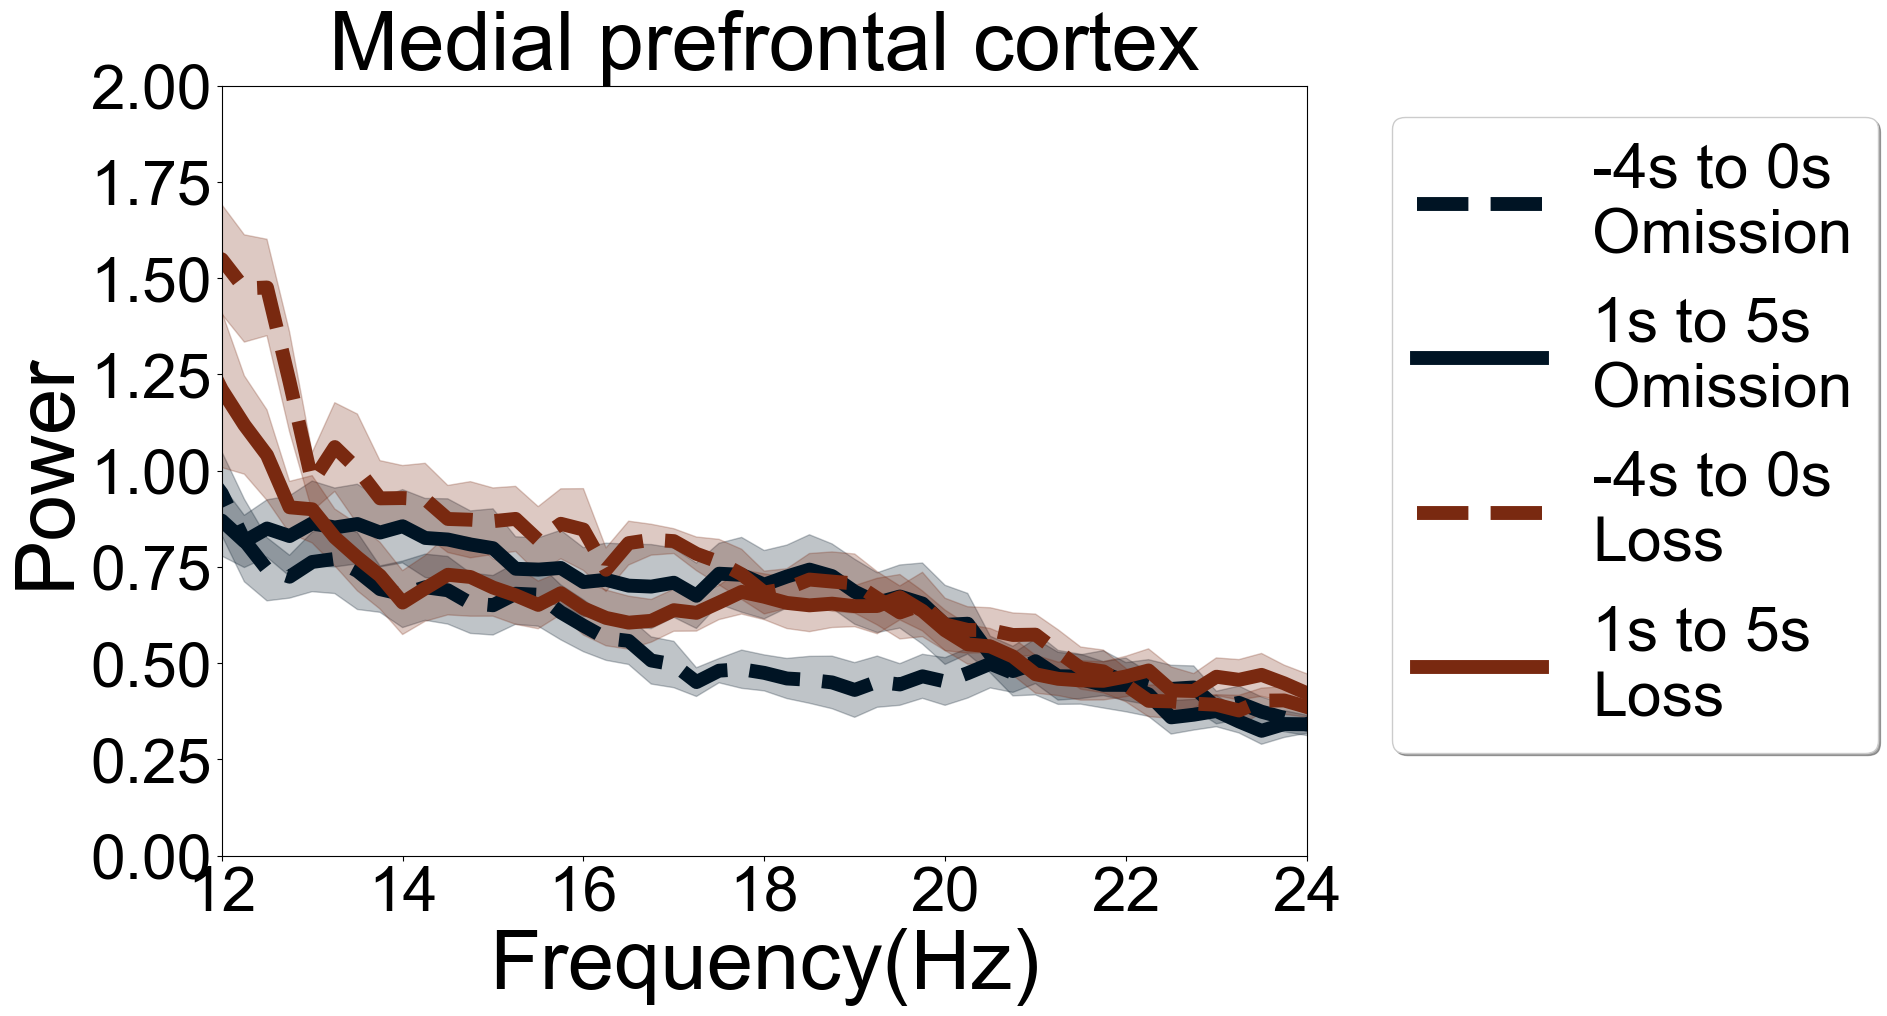

In [76]:
for channel in channel_id_to_brain_region.keys():
    print(channel)
    print(trial_type)
    plt.rcParams["figure.figsize"] = (14,10)
    fig, ax = plt.subplots()
    for trial_type in trials_without_reward:


        ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="-4s to 0s\n{}".format(trial_type.capitalize()), linestyle="--", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
        
        ax.plot(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="1s to 5s\n{}".format(trial_type.capitalize()), linestyle="-", color=trial_type_to_color[trial_type], linewidth = LINWID)
        ax.fill_between(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
    ax.set_xlabel("Frequency(Hz)", fontsize = AXESLABEL)
    ax.set_ylabel("Power", fontsize = AXESLABEL)
    plt.xticks(fontsize = AXESTICKS, family="Arial")
    plt.yticks(fontsize = AXESTICKS, family="Arial")

    
    ax.set_xlim(12,24)
    ax.set_ylim(0,brain_region_to_ylim[channel_id_to_brain_region[channel]])

#     plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0, xmax=0.33, color='#3C1508', linestyle='-', linewidth=LINWID)
#     plt.text(2, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Delta', fontsize = AXESLABEL, ha='center', color='#3C1508')
#     plt.axhline(y=brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.85, xmin=0.33, xmax=1, color='#9F6D00', linestyle='-', linewidth=LINWID)
#     plt.text(8, brain_region_to_ylim[channel_id_to_brain_region[channel]] * 0.885, 'Theta', fontsize = AXESLABEL, ha='center', color='#9F6D00')
    
    # ax.set_yscale("log")
    plt.title("{}".format(channel_id_to_brain_region[channel]), fontsize = TITLESIZE)
    plt.legend(fontsize = LEGSIZE, fancybox=True, frameon = True, shadow=True, loc="upper left", bbox_to_anchor=(1.05, 1))
#     plt.tight_layout()



#     plt.savefig("./proc/plots/lfp_{}_{}_omission_trials.png".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
#     plt.savefig("./proc/plots/lfp_{}_{}_omission_trials.svg".format(subject_id, channel_id_to_brain_region[channel]), bbox_inches='tight')
    plt.show()
